<a href="https://colab.research.google.com/github/Pooret/inspiritai/blob/main/Copy_of_Tyler_Sanjay_project_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.1/33.1 MB 61.6 MB/s eta 0:00:00


In [7]:
# imports

import pandas as pd
import numpy as np
from tqdm import tqdm

import ast

from sklearn.model_selection import train_test_split
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
from rdkit import Chem, RDLogger
from rdkit.Chem import BondType, Draw
from rdkit.Chem.Draw import MolsToGridImage
from rdkit.Chem import PandasTools

In [8]:
# mount your drive to access your data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## In your google drive, there should be a `chembl_33_data.tar.gz` file. Locate that in the files tab on the left and copy and paste it's path into the line below.

 ### e.g. If the file pathway is `/content/drive/MyDrive/Datasets/chemdata/Chembl_33_db/chembl_33_data.tar.gz` the the code below will look this this:

 ### `!tar -xzf /content/drive/MyDrive/Datasets/chemdata/Chembl_33_db/chembl_33_data.tar.gz -C /content/`

In [9]:
!tar -xzf  /content/drive/MyDrive/Datasets/chemdata/Chembl_33_db/chembl_33_data.tar.gz -C /content/

tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.provenance'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.metadata:kMDItemWhereFroms'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.macl'


In [10]:
# load data into pandas dataframe
df = pd.read_csv("/content/data.csv")

# examine first 5 rows of data
df.head()

,molregno,canonical_smiles,activity_id,standard_type,standard_value,standard_units,assay_id,tid,target_chembl_id,organism,...,qed_weighted,mw_monoisotopic,hba_lipinski,hbd_lipinski,num_lipinski_ro5_violations,np_likeness_score,bei,le,lle,sei
0,10,c1cc2cc(c1)-c1cccc(c1)C[n+]1ccc(c3ccccc31)NCCC...,492214,IC50,110.0,nM,200081,104828,CHEMBL2547,Rattus norvegicus,...,0.17,606.3712,4.0,2.0,2.0,0.13,NaN,NaN,NaN,NaN
1,23,O=C1O/C(=C/Br)CCC1c1cccc2ccccc12,14394768,Potency,73078.0,nM,1301803,104173,CHEMBL6152,Trypanosoma brucei,...,0.72,316.0099,2.0,0.0,0.0,0.52,21.61,0.49,2.35,26.06
2,24,O=C1O/C(=C/I)CCC1c1cccc2ccccc12,294832,IC50,30.0,nM,156048,11934,CHEMBL3213,Homo sapiens,...,0.55,363.9960,2.0,0.0,0.0,0.49,20.66,0.54,2.98,28.60
3,25,C#C/C=C1\CCC(c2cccc3ccccc23)C(=O)O1,280316,IC50,95.0,nM,156048,11934,CHEMBL3213,Homo sapiens,...,0.58,262.0994,2.0,0.0,0.0,0.52,26.77,0.48,3.24,26.70
4,26,O=C1O/C(=C\I)CCC1c1cccc2ccccc12,271844,IC50,190.0,nM,156048,11934,CHEMBL3213,Homo sapiens,...,0.55,363.9960,2.0,0.0,0.0,0.49,18.46,0.48,2.18,25.56


,molregno,canonical_smiles,activity_id,standard_type,standard_value,standard_units,assay_id,tid,target_chembl_id,organism,...,mw_monoisotopic,hba_lipinski,hbd_lipinski,num_lipinski_ro5_violations,np_likeness_score,bei,le,lle,sei,molecule_drawing
0,10,c1cc2cc(c1)-c1cccc(c1)C[n+]1ccc(c3ccccc31)NCCC...,492214,IC50,1.100000e+02,nM,200081,104828,CHEMBL2547,Rattus norvegicus,...,606.3712,4.0,2.0,2.0,0.13,NaN,NaN,NaN,NaN,
1,23,O=C1O/C(=C/Br)CCC1c1cccc2ccccc12,14394768,Potency,7.307800e+04,nM,1301803,104173,CHEMBL6152,Trypanosoma brucei,...,316.0099,2.0,0.0,0.0,0.52,21.61,0.49,2.35,26.06,
2,24,O=C1O/C(=C/I)CCC1c1cccc2ccccc12,294832,IC50,3.000000e+01,nM,156048,11934,CHEMBL3213,Homo sapiens,...,363.9960,2.0,0.0,0.0,0.49,20.66,0.54,2.98,28.60,
3,25,C#C/C=C1\CCC(c2cccc3ccccc23)C(=O)O1,280316,IC50,9.500000e+01,nM,156048,11934,CHEMBL3213,Homo sapiens,...,262.0994,2.0,0.0,0.0,0.52,26.77,0.48,3.24,26.70,
4,26,O=C1O/C(=C\I)CCC1c1cccc2ccccc12,271844,IC50,1.900000e+02,nM,156048,11934,CHEMBL3213,Homo sapiens,...,363.9960,2.0,0.0,0.0,0.49,18.46,0.48,2.18,25.56,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,169,CCCCCC(=O)OCC1CN(C(=O)c2cc(OC)c(OC)c(OC)c2)CCN...,69964,IC50,2.900000e+02,nM,164922,10014,CHEMBL5136,Cavia porcellus,...,602.2839,12.0,0.0,2.0,-0.38,NaN,NaN,NaN,NaN,
96,170,Cc1nccn1CCCCc1ccc(CC(=O)N[C@H](CO)Cc2ccc(OCCC3...,658970,IC50,6.230000e+04,nM,141302,104853,CHEMBL366,Homo sapiens,...,588.4039,7.0,4.0,2.0,-0.49,7.70,0.14,-1.19,4.43,
97,171,COc1cc(C(=O)N2CCN(C(=O)c3cc(OC)c(OC)c(OC)c3)C(...,67493,IC50,1.000000e+05,nM,164922,50607,CHEMBL5136,Oryctolagus cuniculus,...,588.2683,12.0,0.0,2.0,-0.45,11.08,0.21,3.23,5.33,
98,173,COc1ccc2c(c1)c(CC(=O)O)c(C)n2C(=O)c1ccc(Cl)cc1,24969005,Solubility,1.513561e+13,nM,2262703,119104,CHEMBL6174,Trypanosoma cruzi,...,357.0768,5.0,1.0,0.0,-0.72,27.54,0.54,5.92,14.38,

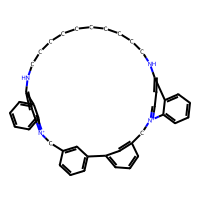
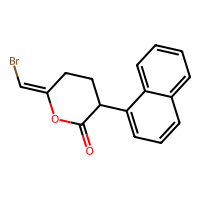
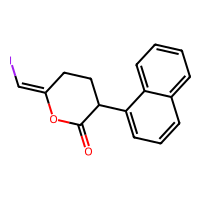
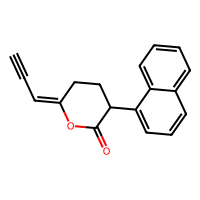
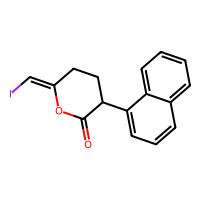
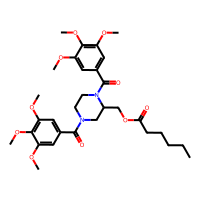
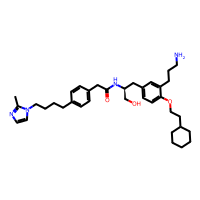
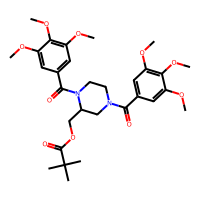
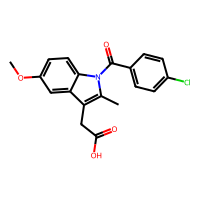
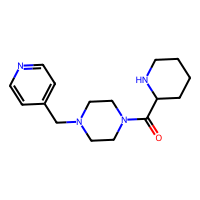

In [11]:
df_small = df.head(100).copy()
PandasTools.AddMoleculeColumnToFrame(df_small, smilesCol = 'canonical_smiles', molCol = 'molecule_drawing')
df_small

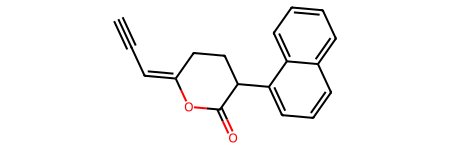

In [12]:
df_new = df_small.canonical_smiles.iloc[3]
Chem.MolFromSmiles(df_new)

In [13]:
print(Chem.MolToMolBlock(Chem.MolFromSmiles(df_new)))


     RDKit          2D

 20 22  0  0  0  0  0  0  0  0999 V2000
   -9.0000    0.0000    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -8.2500   -1.2990    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -7.5000   -2.5981    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -6.0000   -2.5981    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -5.2500   -1.2990    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -3.7500   -1.2990    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -3.0000   -2.5981    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -1.5000   -2.5981    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -0.7500   -3.8971    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.7500   -3.8971    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    1.5000   -2.5981    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.7500   -1.2990    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    1.5000    0.0000    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.7500    1.2990    0

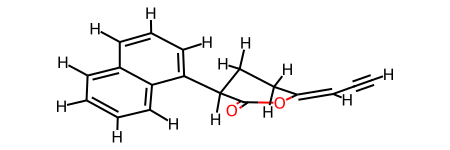

In [14]:
from rdkit.Chem import AllChem
df_newwithH = Chem.AddHs(Chem.MolFromSmiles(df_new, sanitize = True))
AllChem.EmbedMolecule(df_newwithH)
df_newwithH.GetNumAtoms()
AllChem.MMFFOptimizeMolecule(df_newwithH)
df_newwithH

In [15]:
print(Chem.MolToMolBlock(df_newwithH))


     RDKit          3D

 34 36  0  0  0  0  0  0  0  0999 V2000
    6.1822    0.0563    1.9035 C   0  0  0  0  0  0  0  0  0  0  0  0
    5.5036   -0.1822    0.9425 C   0  0  0  0  0  0  0  0  0  0  0  0
    4.7113   -0.4671   -0.2017 C   0  0  0  0  0  0  0  0  0  0  0  0
    3.3698   -0.4917   -0.1953 C   0  0  0  0  0  0  0  0  0  0  0  0
    2.5040   -0.2001    0.9922 C   0  0  0  0  0  0  0  0  0  0  0  0
    1.2183    0.4685    0.5454 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.4915   -0.4360   -0.4484 C   0  0  0  0  0  0  0  0  0  0  0  0
   -0.8581    0.2005   -0.8010 C   0  0  0  0  0  0  0  0  0  0  0  0
   -0.8997    1.1861   -1.8090 C   0  0  0  0  0  0  0  0  0  0  0  0
   -2.0917    1.8106   -2.1567 C   0  0  0  0  0  0  0  0  0  0  0  0
   -3.2661    1.4763   -1.4939 C   0  0  0  0  0  0  0  0  0  0  0  0
   -3.2665    0.5231   -0.4676 C   0  0  0  0  0  0  0  0  0  0  0  0
   -4.4695    0.2228    0.1931 C   0  0  0  0  0  0  0  0  0  0  0  0
   -4.5092   -0.7064    1

In [16]:
df['num_lipinski_ro5_violations']

,num_lipinski_ro5_violations
0,2.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
999995,2.0
999996,2.0
999997,1.0
999998,1.0


In [17]:
new_df = df[df['num_lipinski_ro5_violations'] < 1]

In [18]:
new_df['standard_type'].unique()

array(['Potency', 'IC50', 'Kd', 'Ki', 'Solubility', 'Km', 'MIC', 'XC50',
       'Selectivity', 'Cmax', 'MIC80', 'MIC50', 'Kp', 'LC50', 'Kinact',
       'GI50', 'MCC', 'CC50', 'Kb', 'pKi', 'TGI', 'pA2', 'IC95', 'TC50',
       'EC50', 'Inhibition', 'ID50', 'fCmax', 'Ratio', 'IC90', 'AC50',
       'ED50', 'Relative IC50', 'T50', 'Kieq', 'K bind', 'P-450 loss',
       'Kis', 'Activity', 'IC30', 'dP/dt', 'MIC90', 'fIC30', 'Protection',
       'Stability', 'Kd2', 'KiAH', 'C50', 'Ri', 'MEC', 'Rate',
       'Binding affinity', 'Plasma level', 'cKi', 'K0.5', 'fEC50',
       'Log Ki', 'Ke', 'CIC', 'Ka', 'IP', 'Ke naloxone', 'pKb', 'INH',
       'Plasma concentration', 'Residual activity', 'MI0.5', 'Ks',
       'K 0.5', 'Cytotoxicity', 'K app', 'KL', 'IC60', 'Log IC50', 'Kif',
       'SC200', 'EC20', 'KiH', 'Ca2+ elevation', 'Ratio Ki', 'K2',
       'alphaKi', 'MIC100', 'XI50', 'Inhibitory activity', 'Affinity',
       'Inflection point', 'Mortality', 'LD50', 'Fluorescence',
       'Ki app (inact

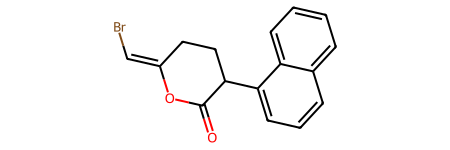

In [19]:
Chem.MolFromSmiles(df['canonical_smiles'].iloc[1])

In [20]:
(new_df['canonical_smiles'].iloc[0])

'O=C1O/C(=C/Br)CCC1c1cccc2ccccc12'

In [21]:
new_df.columns

Index(['molregno', 'canonical_smiles', 'activity_id', 'standard_type',
       'standard_value', 'standard_units', 'assay_id', 'tid',
       'target_chembl_id', 'organism', 'pref_name', 'mw_freebase', 'alogp',
       'hba', 'hbd', 'psa', 'rtb', 'ro3_pass', 'num_ro5_violations',
       'cx_most_apka', 'cx_most_bpka', 'cx_logp', 'cx_logd',
       'molecular_species', 'full_molformula', 'full_mwt', 'aromatic_rings',
       'heavy_atoms', 'qed_weighted', 'mw_monoisotopic', 'hba_lipinski',
       'hbd_lipinski', 'num_lipinski_ro5_violations', 'np_likeness_score',
       'bei', 'le', 'lle', 'sei'],
      dtype='object')

In [22]:
new_df['standard_type'].unique()

array(['Potency', 'IC50', 'Kd', 'Ki', 'Solubility', 'Km', 'MIC', 'XC50',
       'Selectivity', 'Cmax', 'MIC80', 'MIC50', 'Kp', 'LC50', 'Kinact',
       'GI50', 'MCC', 'CC50', 'Kb', 'pKi', 'TGI', 'pA2', 'IC95', 'TC50',
       'EC50', 'Inhibition', 'ID50', 'fCmax', 'Ratio', 'IC90', 'AC50',
       'ED50', 'Relative IC50', 'T50', 'Kieq', 'K bind', 'P-450 loss',
       'Kis', 'Activity', 'IC30', 'dP/dt', 'MIC90', 'fIC30', 'Protection',
       'Stability', 'Kd2', 'KiAH', 'C50', 'Ri', 'MEC', 'Rate',
       'Binding affinity', 'Plasma level', 'cKi', 'K0.5', 'fEC50',
       'Log Ki', 'Ke', 'CIC', 'Ka', 'IP', 'Ke naloxone', 'pKb', 'INH',
       'Plasma concentration', 'Residual activity', 'MI0.5', 'Ks',
       'K 0.5', 'Cytotoxicity', 'K app', 'KL', 'IC60', 'Log IC50', 'Kif',
       'SC200', 'EC20', 'KiH', 'Ca2+ elevation', 'Ratio Ki', 'K2',
       'alphaKi', 'MIC100', 'XI50', 'Inhibitory activity', 'Affinity',
       'Inflection point', 'Mortality', 'LD50', 'Fluorescence',
       'Ki app (inact

In [23]:
wanted_values = ['Potency', 'IC50', 'Kd', 'Ki', 'Solubility', 'Km', 'MIC', 'XC50',
       'Selectivity', 'Cmax', 'MIC80', 'MIC50', 'Kp', 'LC50', 'Kinact',
       'GI50', 'MCC', 'CC50', 'Kb', 'pKi', 'TGI', 'pA2', 'IC95', 'TC50',
       'EC50', 'Inhibition', 'ID50', 'fCmax', 'Ratio', 'IC90', 'AC50']
wanted_values

['Potency',
 'IC50',
 'Kd',
 'Ki',
 'Solubility',
 'Km',
 'MIC',
 'XC50',
 'Selectivity',
 'Cmax',
 'MIC80',
 'MIC50',
 'Kp',
 'LC50',
 'Kinact',
 'GI50',
 'MCC',
 'CC50',
 'Kb',
 'pKi',
 'TGI',
 'pA2',
 'IC95',
 'TC50',
 'EC50',
 'Inhibition',
 'ID50',
 'fCmax',
 'Ratio',
 'IC90',
 'AC50']

In [24]:
new_df[new_df['standard_type'] == 'Potency']


,molregno,canonical_smiles,activity_id,standard_type,standard_value,standard_units,assay_id,tid,target_chembl_id,organism,...,qed_weighted,mw_monoisotopic,hba_lipinski,hbd_lipinski,num_lipinski_ro5_violations,np_likeness_score,bei,le,lle,sei
1,23,O=C1O/C(=C/Br)CCC1c1cccc2ccccc12,14394768,Potency,7.307800e+04,nM,1301803,104173,CHEMBL6152,Trypanosoma brucei,...,0.72,316.0099,2.0,0.0,0.0,0.52,21.61,0.49,2.35,26.06
53,111,Cc1cc(CC(=O)[O-])n(C)c1C(=O)c1ccc(Cl)cc1.[Na+],15598675,Potency,1.000000e+05,nM,1495415,103989,CHEMBL612545,Plasmodium falciparum,...,0.88,291.0662,4.0,1.0,0.0,-0.65,17.48,0.35,2.25,8.60
56,115,CN1CCC[C@H]1c1cccnc1,22970864,Potency,4.570882e+08,nM,2089382,118698,CHEMBL614818,Torpedo californica,...,0.63,162.1157,2.0,0.0,0.0,-0.41,67.80,1.25,9.15,68.20
75,146,CC1COc2c(N3CCN(C)CC3)c(F)cc3c(=O)c(C(=O)O)cn1c23,24958979,Potency,3.367000e+07,nM,2260153,118698,CHEMBL615052,Trypanosoma brucei brucei,...,0.87,361.1438,7.0,1.0,0.0,-0.21,16.12,0.31,4.28,7.76
76,147,CCn1cc(C(=O)O)c(=O)c2ccc(C)nc21,24813526,Potency,1.760000e+07,nM,2224252,118698,CHEMBL615022,Streptococcus pyogenes,...,0.85,232.0848,5.0,1.0,0.0,-0.98,18.41,0.34,2.86,5.92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
997571,1510946,O=[N+]([O-])c1ccccc1/C=N/N1CCN(Cc2ccccc2)CC1,15478361,Potency,8.912510e+04,nM,1495346,104016,CHEMBL612545,Plasmodium falciparum,...,0.48,324.1586,6.0,0.0,0.0,-1.68,NaN,NaN,NaN,NaN
997572,1510947,C/C(=N\N1CCN(Cc2ccccc2Cl)CC1)c1ccc([N+](=O)[O-...,15570211,Potency,4.200000e+05,nM,1495346,104016,CHEMBL614818,Plasmodium falciparum,...,0.45,372.1353,6.0,0.0,0.0,-1.80,13.14,0.26,1.11,7.91
997574,1510949,Cn1cccc1/C=N/N1CCN(Cc2ccccc2)CC1,12627584,Potency,1.000000e+05,nM,937879,105144,CHEMBL612545,Trypanosoma brucei brucei (strain 927/4 GUTat1...,...,0.80,282.1844,4.0,0.0,0.0,-1.62,19.48,0.36,3.32,23.14
997747,1511168,COc1ccc(C(CC(=O)N2CCCC2)c2c(O)cc(OC)cc2OC)cc1,12986917,Potency,2.909290e+04,nM,954305,103069,CHEMBL1075138,Homo sapiens,...,0.79,385.1889,6.0,1.0,0.0,-0.18,NaN,NaN,NaN,NaN


/usr/local/lib/python3.10/dist-packages/rdkit/Chem/PandasTools.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame[molCol] = frame[smilesCol].map(Chem.MolFromSmiles)


,molregno,canonical_smiles,activity_id,standard_type,standard_value,standard_units,assay_id,tid,target_chembl_id,organism,...,mw_monoisotopic,hba_lipinski,hbd_lipinski,num_lipinski_ro5_violations,np_likeness_score,bei,le,lle,sei,molecule_drawing
3,25,C#C/C=C1\CCC(c2cccc3ccccc23)C(=O)O1,280316,IC50,95.0000,nM,156048,11934,CHEMBL3213,Homo sapiens,...,262.0994,2.0,0.0,0.0,0.52,26.77,0.48,3.24,26.70,
5,31,COc1cc2nc(N3CCN(C(=O)C4CC4c4ccccc4)CC3)nc(N)c2...,325753,IC50,0.5129,nM,33572,104304,CHEMBL1907610,Rattus norvegicus,...,433.2114,8.0,2.0,0.0,-0.89,21.43,0.40,6.61,9.90,
6,33,COc1cc2nc(N3CCN(S(=O)(=O)c4cccs4)CC3)nc(N)c2cc1OC,343861,IC50,33.8800,nM,33572,104304,CHEMBL1907610,Rattus norvegicus,...,435.1035,9.0,2.0,0.0,-1.78,17.15,0.35,5.67,6.74,
20,59,COc1cc2nc(N3CCN(C(=O)CCc4ccccc4)CC3)nc(N)c2cc1OC,331005,IC50,3.3880,nM,33572,104304,CHEMBL1907610,Rattus norvegicus,...,421.2114,8.0,2.0,0.0,-0.91,20.10,0.37,5.96,9.03,
21,60,COc1ccc(/C=C/C(=O)N2CCN(c3nc(N)c4cc(OC)c(OC)cc...,331003,IC50,3.3880,nM,33574,104304,CHEMBL1907610,Rattus norvegicus,...,449.2063,9.0,2.0,0.0,-0.67,18.84,0.35,5.87,8.22,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999987,1513841,Cc1cc2c(N3CCNCC3)nc(N)nc2[nH]1,12634097,Ki,2670.0000,nM,935304,11290,CHEMBL3759,Homo sapiens,...,232.1436,6.0,4.0,0.0,-0.98,23.99,0.45,5.31,6.73,
999988,1513842,Nc1nc(N2CCNCC2)c2cc(-c3ccccc3)[nH]c2n1,12634096,Ki,1410.0000,nM,935304,11290,CHEMBL3759,Homo sapiens,...,294.1593,6.0,4.0,0.0,-0.82,19.88,0.36,4.23,7.06,
999989,1513843,CN1CCN(c2nc(N)nc3[nH]c(-c4ccccc4)cc23)CC1,12634095,Ki,5400.0000,nM,935304,11290,CHEMBL3759,Homo sapiens,...,308.1749,6.0,3.0,0.0,-0.98,17.08,0.31,3.31,7.11,
999990,1513844,CN1CCN(c2nc(N)nc3[nH]c(-c4ccc(F)cc4)cc23)CC1,12634094,Ki,2640.0000,nM,935304,11290,CHEMBL3759,Homo sapiens,...,326.1655,6.0,3.0,0.0,-1.24,17.09,0.32,3.48,7.53,

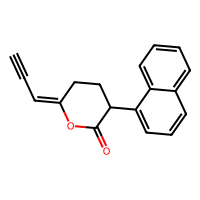
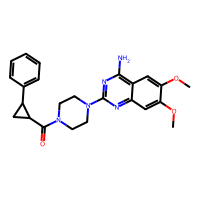
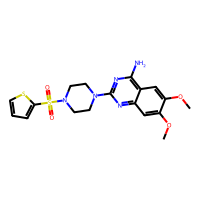
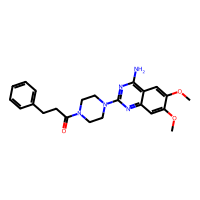
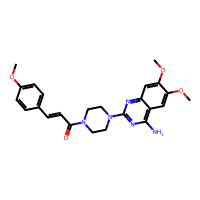
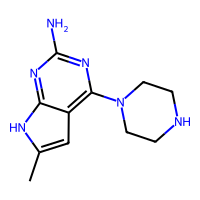
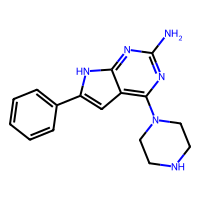
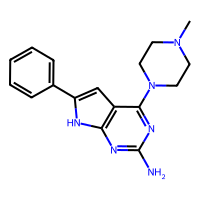
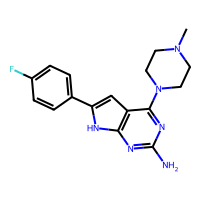
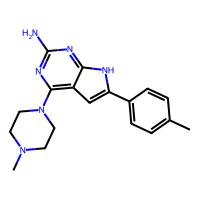

In [25]:
lip_df = new_df[(new_df['num_lipinski_ro5_violations'] == 0) & (new_df['hba_lipinski'] <= 10) & (new_df['mw_monoisotopic'] < 480) & (new_df['le']>0.3) & (new_df['lle']>3)]
PandasTools.AddMoleculeColumnToFrame(lip_df, smilesCol = 'canonical_smiles', molCol = 'molecule_drawing')
lip_df


In [21]:
lip_df['canonical_smiles'].iloc[0]

'C#C/C=C1\\CCC(c2cccc3ccccc23)C(=O)O1'

In [22]:

1+1

2

In [4]:
import math
import torch
import torch.nn as nn

num_classes = 3
vocab_size = 10000
batch_size = 8
d_model = 512
num_heads = 8
num_layers = 6
d_ff = 2048
sequence_length = 256
dropout = 0.1

class PositionalEncoder(nn.Module):
  def __init__(self, d_model, max_length):
    super(PositionalEncoder, self).__init__()
    self.d_model = d_model
    self.max_length = max_length

    # Initialize the positional encoding matrix
    pe = torch.zeros(max_length, d_model)

    position = torch.arange(0, max_length, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float)) * - (math.log(10000.0) / d_model)

    # Calculate and assign position encodings to the matrix
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    pe = pe.unsqueeze(0)
    self.register_buffer('pe', pe)

    # Update the embeddings tensor adding the positional encodings
  def forward(self, x):
      x = x + self.pe[:, :x.size(1)]
      return x

class MultiHeadAttention(nn.Module):
  def __init__(self, d_model, num_heads):
      super(MultiHeadAttention, self).__init__()

      # Set the number of attention heads
      self.num_heads = num_heads
      self.d_model = d_model
      self.head_dim = d_model // num_heads

  # Set up the linear transformations
      self.query_linear = nn.Linear(d_model, d_model)
      self.key_linear = nn.Linear(d_model, d_model)
      self.value_linear = nn.Linear(d_model, d_model)
      self.output_linear = nn.Linear(d_model, d_model)

  def split_heads(self, x, batch_size):
    # Split the sequence embeddings in x across the attention heads
    x = x.view(batch_size, -1, self.num_heads, self.head_dim)
    return x.permute(0, 2, 1, 3).contiguous().view(batch_size * self.num_heads, -1, self.head_dim)

  def compute_attention(self, query, key, mask=None):
    # Compute dot-product attention scores
    scores = torch.matmul(query, key.permute(1, 2, 0))
    if mask is not None:
        scores = scores.masked_fill(mask == 0, float("-1e20"))
    # Normalize attention scores into attention weights
    attention_weights = F.softmax(scores, dim=-1)
    return attention_weights

  def forward(self, query, key, value, mask=None):
    batch_size = query.size(0)

    query = self.split_heads(self.query_linear(query), batch_size)
    key = self.split_heads(self.key_linear(key), batch_size)
    value = self.split_heads(self.value_linear(value), batch_size)

    attention_weights = self.compute_attention(query, key, mask)

    # Multiply attention weights by values, concatenate and linearly project outputs
    output = torch.matmul(attention_weights, value)
    output = output.view(batch_size, self.num_heads, -1, self.head_dim).permute(0, 2, 1, 3).contiguous().view(batch_size, -1, self.d_model)
    return self.output_linear(output)

class FeedForwardSubLayer(nn.Module):
    # Specify the two linear layers' input and output sizes
    def __init__(self, d_model, d_ff):
        super(FeedForwardSubLayer, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()

	# Apply a forward pass
    def forward(self, x):
        return self.relu(self.fc2(self.fc1(x)))

# Complete the initialization of elements in the encoder layer
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = FeedForwardSubLayer(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        attn_output = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        return self.norm2(x + self.dropout(ff_output))

class TransformerEncoder(nn.Module):
    def __init__(self, vocab_size, d_model, num_layers, num_heads, d_ff, dropout, max_sequence_length):
        super(TransformerEncoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = PositionalEncoder(d_model, max_sequence_length)
        # Define a stack of multiple encoder layers
        self.layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])

    # Complete the forward pass method
    def forward(self, x, mask):
        x = self.embedding(x)
        x = self.positional_encoding(x)
        for layer in self.layers:
            x = layer(x, mask)
        return x

class ClassifierHead(nn.Module):
    def __init__(self, d_model, num_classes):
        super(ClassifierHead, self).__init__()
        # Add linear layer for multiple-class classification
        self.fc = nn.Linear(d_model, num_classes)

    def forward(self, x):
        logits = self.fc(x[:, 0, :])
        # Obtain log class probabilities upon raw outputs
        return F.log_softmax(logits, dim=-1)

input_sequence = torch.randint(0, vocab_size, (batch_size, sequence_length))
mask = torch.randint(0, 2, (sequence_length, sequence_length))

# Instantiate the encoder transformer's body and head
encoder = TransformerEncoder(vocab_size, d_model, num_layers, num_heads, d_ff, dropout, max_sequence_length=sequence_length)
classifier = ClassifierHead(d_model, num_classes)

# Complete the forward pass
output = encoder(input_sequence, mask)
classification = classifier(output)
print("Classification outputs for a batch of ", batch_size, "sequences:")
print(classification)

RuntimeError: The size of tensor a (64) must match the size of tensor b (256) at non-singleton dimension 0

Vocabulary: ['<PAD>', '<SOS>', '<EOS>', '[', '.', 'H', 'P', '2', 'a', 'o', 'n', '/', '3', '1', 'N', '-', 'S', '=', 'B', '#', 'l', ']', 'r', 'F', '+', 'I', '\\', '@', 's', 'C', '(', 'O', ')', 'c', '4', '5']
Number of SMILES strings: 1000
Vocabulary length: 36
Max Length: 80
Padded SMILES list shape: (1000, 80)
Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 96s 3s/step - accuracy: 0.4151 - loss: 2.4754 - val_accuracy: 0.6102 - val_loss: 1.5466
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 420ms/step - accuracy: 0.6073 - loss: 1.5333 - val_accuracy: 0.6208 - val_loss: 1.4179
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 407ms/step - accuracy: 0.6160 - loss: 1.4267 - val_accuracy: 0.6413 - val_loss: 1.3173
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 428ms/step - accuracy: 0.6253 - loss: 1.3382 - val_accuracy: 0.6600 - val_loss: 1.1860
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 399ms/step - accuracy: 0.6462 - loss: 1.2196 - val_accuracy: 0.6578 - val_loss: 1.1589
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 

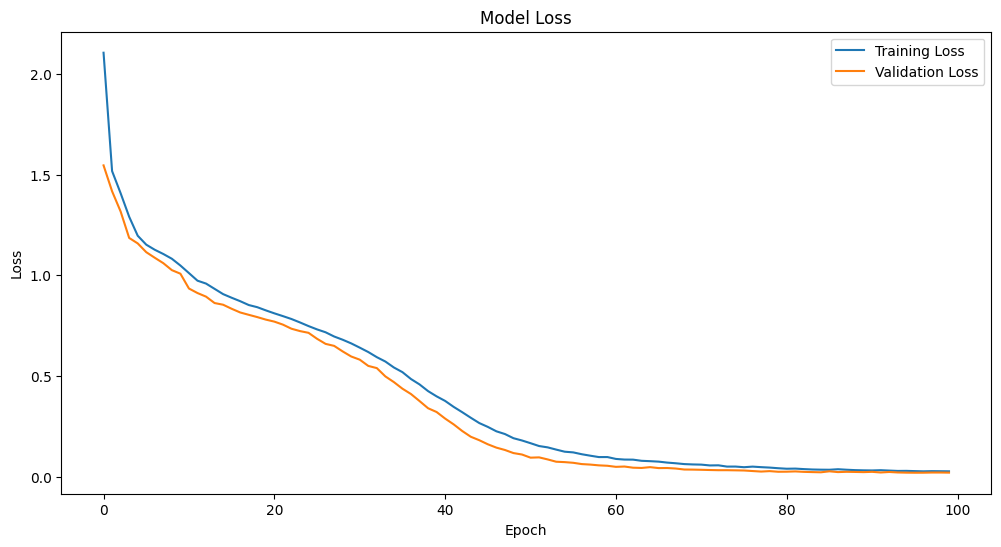

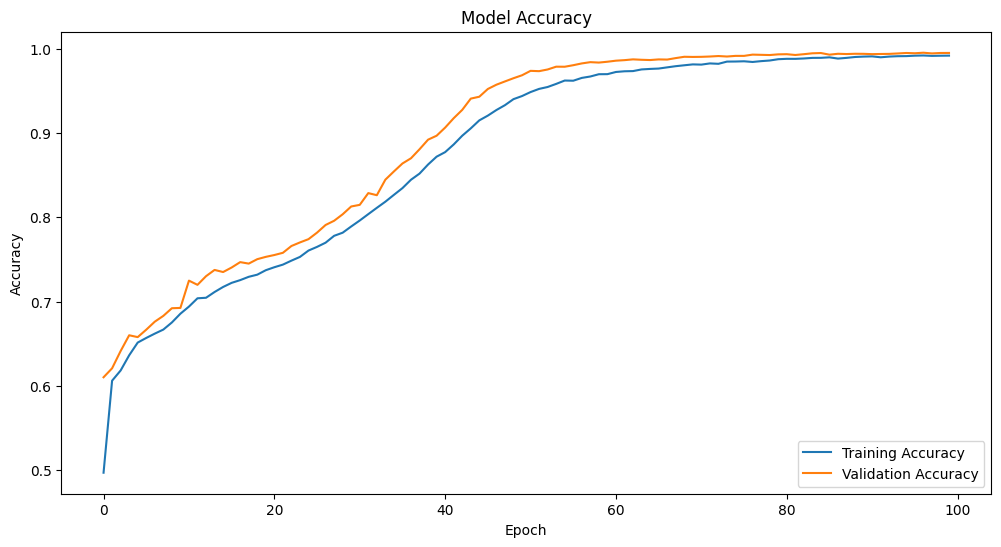

In [29]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model, Sequential, optimizers, losses
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm

# Example SMILES list
smiles_list = lip_df.iloc[:1000]['canonical_smiles'].tolist()

# Add special tokens with reserved indices
special_tokens = ['<PAD>', '<SOS>', '<EOS>']
vocab = special_tokens + list(set("".join(smiles_list)))

# Create character-to-index and index-to-character mappings
chars_to_index = {char: index for index, char in enumerate(vocab)}
index_to_chars = {index: char for index, char in enumerate(vocab)}

# Define the maximum length for padding (adding 2 for the <SOS> and <EOS> tokens)
max_length = max(len(smiles) for smiles in smiles_list) + 2

# Encode all SMILES strings
encoded_smiles_list = [
    [chars_to_index['<SOS>']] + [chars_to_index[char] for char in smiles] + [chars_to_index['<EOS>']]
    for smiles in smiles_list
]

# Pad sequences to the same length using <PAD> token
padded_smiles_list = pad_sequences(encoded_smiles_list, maxlen=max_length, padding='post', value=chars_to_index['<PAD>'])

print(f"Vocabulary: {vocab}")
print(f"Number of SMILES strings: {len(smiles_list)}")
print(f"Vocabulary length: {len(vocab)}")
print(f"Max Length: {max_length}")
print(f"Padded SMILES list shape: {padded_smiles_list.shape}")

# Convert to numpy array
X = np.array(padded_smiles_list)

# Create the target sequences (shifted by one time step)
y = np.zeros_like(X)
y[:, :-1] = X[:, 1:]
y[:, -1] = chars_to_index['<PAD>']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

class PositionalEncoding(layers.Layer):
    def __init__(self, max_position, d_model):
        super(PositionalEncoding, self).__init__()
        self.max_position = max_position
        self.d_model = d_model
        self.pos_encoding = self.positional_encoding(max_position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            np.arange(position)[:, np.newaxis],
            np.arange(d_model)[np.newaxis, :],
            d_model
        )
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
        pos_encoding = angle_rads[np.newaxis, ...]
        return tf.cast(pos_encoding, dtype=tf.float32)

    def call(self, inputs):
        # Get the current sequence length of inputs
        seq_len = tf.shape(inputs)[1]

        # Ensure pos_encoding is large enough for seq_len
        pos_encoding = self.pos_encoding[:, :seq_len, :]

        # # Debugging: print shapes of tensors
        # print("Shape of inputs:", tf.shape(inputs))
        # print("Shape of pos_encoding:", tf.shape(pos_encoding))

        # Broadcasting will naturally handle the batch size
        return inputs + pos_encoding




# Transformer Block class
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


# Molecular Transformer class
class MolecularTransformer(Model):
    def __init__(self, vocab_size, max_length, embed_dim, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout=0.1):
        super(MolecularTransformer, self).__init__()
        self.embedding = layers.Embedding(vocab_size, embed_dim)
        self.pos_encoding = PositionalEncoding(max_length, embed_dim)
        self.dropout = layers.Dropout(dropout)
        self.transformer_blocks = [TransformerBlock(embed_dim, num_heads, ff_dim, dropout) for _ in range(num_transformer_blocks)]
        self.mlp = Sequential(
            [layers.Dense(dim, activation="relu") for dim in mlp_units] +
            [layers.Dense(vocab_size)]
        )
        self.chars_to_index = None  # Placeholder
        self.index_to_chars = None  # Placeholder

    def call(self, inputs, training):
        x = self.embedding(inputs)
        x = self.pos_encoding(x)
        x = self.dropout(x, training=training)
        for transformer_block in self.transformer_blocks:
            x = transformer_block(x, training=training)
        return self.mlp(x)

    def generate_smiles(self, start_token, max_length, temperature=1.0):
        input_seq = tf.constant([[start_token]], dtype=tf.int32)
        generated_smiles = []

        for _ in range(max_length):
            predictions = self(input_seq, training=False)
            predictions = predictions[:, -1, :] / temperature
            predicted_id = tf.random.categorical(predictions, num_samples=1)[-1, 0].numpy()

            generated_smiles.append(predicted_id)
            input_seq = tf.concat([input_seq, tf.expand_dims([predicted_id], 0)], axis=-1)

            if predicted_id == chars_to_index['<EOS>']:
                break

        # Convert to SMILES string, filtering out <PAD> tokens
        smiles_string = ''.join([self.index_to_chars[i] for i in generated_smiles if i != self.chars_to_index['<PAD>']])
        print(smiles_string)
        return smiles_string


# Hyperparameters

# Constants for the model

DROPOUT = 0.1
EPOCHS = 100
BATCH_SIZE = 64  # Adjust based on memory availability
LEARNING_RATE = 1e-4  # Adjusted learning rate
NUM_TRANSFORMER_BLOCKS = 8
FF_DIM = 512
MLP_UNITS = [256, 256]
TEMPERATURE = 1.0  # Temperature for generation
CLIPVALUE = 1.0  # Gradient clipping value
VOCAB_SIZE = len(vocab)
MAX_LENGTH = max_length
EMBED_DIM = 256
NUM_HEADS = 12



# Create and compile the model
model = MolecularTransformer(
    vocab_size=VOCAB_SIZE,
    max_length=MAX_LENGTH,
    embed_dim=EMBED_DIM,
    num_heads=NUM_HEADS,
    ff_dim=FF_DIM,
    num_transformer_blocks=NUM_TRANSFORMER_BLOCKS,
    mlp_units=MLP_UNITS,
    dropout=DROPOUT
)

# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Learning rate schedule (optional)
lr_schedule = ExponentialDecay(
    initial_learning_rate=LEARNING_RATE,
    decay_steps=10000,
    decay_rate=0.9,
    staircase=True
)

# Compile the model again if using a learning rate schedule
optimizer = optimizers.Adam(learning_rate=lr_schedule)
loss = losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [30]:
# Function to generate SMILES strings with temperature scaling
def generate_smiles(model, start_token, max_length, chars_to_index, index_to_chars, temperature=1.0):
    # Initialize the input sequence with the start token
    input_seq = [chars_to_index[start_token]]
    for _ in range(max_length - 1):
        # Pad the sequence
        padded_seq = pad_sequences([input_seq], maxlen=max_length, padding='post', value=chars_to_index['<PAD>'])
        # Predict the next character
        pred = model.predict(padded_seq, verbose=0)
        pred = pred[0][len(input_seq) - 1]

        # Apply temperature scaling
        pred = np.log(pred + 1e-9) / temperature
        exp_pred = np.exp(pred)
        pred = exp_pred / np.sum(exp_pred)
        next_char = np.random.choice(len(pred), p=pred)
        # Append the next character to the sequence
        input_seq.append(next_char)
        # If EOS token is generated, stop the generation
        if next_char == chars_to_index['<EOS>']:
            break
    # Convert the sequence of indices to characters
    smiles = ''.join([index_to_chars[i] for i in input_seq if i != chars_to_index['<PAD>'] and i != chars_to_index['<EOS>']])
    print(smiles.split("<SOS>")[-1])
    return smiles.split("<SOS>")[-1]

def evaluate_generated_smiles(generated_smiles_list):
    from rdkit import Chem
    from rdkit import RDLogger

    # Function to check the validity of generated SMILES strings using RDKit
    def is_valid_smiles(smiles):
        mol = Chem.MolFromSmiles(smiles)
        return mol is not None

    # Suppress RDKit warnings
    RDLogger.DisableLog('rdApp.*')

    valid_smiles = []

    for smiles in generated_smiles_list:
        if is_valid_smiles(smiles) and len(smiles) > 0:
            valid_smiles.append(smiles)

    validity = len(valid_smiles) / len(generated_smiles_list) * 100
    if len(valid_smiles) > 0:
      unique = len(list(set(valid_smiles))) / len(valid_smiles) * 100
    else:
      unique = 0
    # Re-enable RDKit warnings if needed
    RDLogger.EnableLog('rdApp.*')

    return validity, unique, list(set(valid_smiles))


model.chars_to_index = chars_to_index  # Assigning the dictionary to the model
model.index_to_chars = index_to_chars  # Assigning the dictionary to the model

# Define starting token and maximum length
start_token = chars_to_index['<SOS>']
max_gen_length = MAX_LENGTH  # Adjust based on your preference

generated_smiles_list = []
for i in tqdm(range(10)):

  generated_smiles = model.generate_smiles(
      start_token=start_token,
      max_length=max_gen_length,
      temperature=1.0  # Adjust temperature for more randomness if needed
  )
  generated_smiles_list.append(generated_smiles)

#print(f"Generated SMILES: {generated_smiles}")


# # Generate a new SMILES string
# new_smiles = generate_smiles(molecular_transformer_model, start_token='<SOS>', max_length=max_length, chars_to_index=chars_to_index, index_to_chars=index_to_chars, temperature=TEMPERATURE)
# print(f"Generated SMILES: {new_smiles}")

# generated_smiles_list = []
# for i in tqdm(range(100)):
#     generated_smiles = generate_smiles(molecular_transformer_model, start_token='<SOS>', max_length=max_length, chars_to_index=chars_to_index, index_to_chars=index_to_chars, temperature=TEMPERATURE)
#     generated_smiles_list.append(generated_smiles)

validity, uniqueness, unique_valid_smiles = evaluate_generated_smiles(generated_smiles_list)
print(f"\nPercent valid: {validity:.3f}%")
print(f"Percent unique: {uniqueness:.3f}%")
print(unique_valid_smiles)

 10%|█         | 1/10 [00:00<00:04,  1.98it/s]

==<EOS>


 20%|██        | 2/10 [00:11<00:55,  6.93s/it]

(/11c1((((((((((((1=(((((((O(((=O(=/O/(/=O\C1=O)((O/1/C1@(=O[O[@1]1+]2+]+]+]a+]+


 30%|███       | 3/10 [00:22<01:00,  8.67s/it]

\111(C(/(((/(((1O=O=O/1O/(C=O1/O=O/O(/@/O(/O\/@=O#O/C@H]1[OC@@@@+a+]1.P<EOS>


 40%|████      | 4/10 [00:32<00:54,  9.16s/it]

(22(((OC==//((((((OO/=O1O/O()=/=((((=([=O(O/C1O/@@1S=O//@\=O=O.1-+]/]a-]+]a]+]@]


 50%|█████     | 5/10 [00:42<00:47,  9.50s/it]

/B(//=((OS((=C((/(O(O((=(=O(O(OC=C[=O1\11/I1(@1/[O@O//@@@@@@@@H]1+<EOS>


 60%|██████    | 6/10 [00:54<00:40, 10.12s/it]

(\1(/=((/(/(((=O=(/((((OC=C(O\=/(=((1(=(]1/@O(CC=OC1C1@@@\/=O\[1+]1]+]2O.Na


 70%|███████   | 7/10 [01:04<00:30, 10.11s/it]

1/1(((\(Oc1((/((O)=O(OO((=C((#(/O\((=(O(\(O(S1[[O)OC=OH]11/(@[OP@H]1a.@/]a+]+]+]


 80%|████████  | 8/10 [01:15<00:21, 10.58s/it]

(11=(((/(=(((/=(C1OO=O/(/C(O/=O/O=O(=O/C=O=O([O[O/O/O./C@@[@[O)1++]+]1]+]+]a]2N+


 90%|█████████ | 9/10 [01:16<00:07,  7.39s/it]

(=<EOS>


100%|██████████| 10/10 [01:27<00:00,  8.78s/it]

/((((C(/(/((=C((((OCO(((=O(OO(=O(=(C((/=(/O)/((O)/O)/O+H]1O)=O)1)[[[C@]\[O.S[O.[

Percent valid: 0.000%
Percent unique: 0.000%
[]


In [84]:
for smiles in generated_smiles_list:
  print("".join(index_to_chars[char] for char in smiles))

CC23)HH]4)))464c))))))))))))))))))c35CC23-]3434444535544F5))45)4445C55)5)C)4)2#C)C)54)4444446444o44
(+))1)CCC#)4))4cc)))444c)))))))43443c6cc14-44)))4))C524443CCCC443434)n44)#))s4)C4)5)5644C4-r)-])46)
)=CC#((S32H43H-c--H444+)))))))#)))45)#3CC2#c4))54F24))))343)))))))))))))))-))))))))))))))))))))))))
C#)))-H2)))))4c-cF4)))44))44444434443)))434-33))CCCCCCC44-cc)))446]4-]4=]1)4)2\4)2)5)4-]44-O)-]4]44
)CCCCC)4)))4244))33)))C44))))))64)))344#44))4))<PAD>3)4ccc4c443443C3+H-H]H]]4C)n2H]3@]4H]-]-H]4H]4-]-]4
C=1)(4)))3n-2343))43c34))))4))))44443)4346c443)33#C64333)))))44=))c4)4))F)4)5)4)4)4)4)4)4)4-)4)+])4
((C))#222H)))4))))))#4nH)))))))))44434cc4243))))))#4)))3)4]5c4))4)4#6]4)C)4-)254C)N)65)2)444<PAD>]44)5)
C)=CC4H22))4533c5C#))3)))4)))))))))))))C543c3)))))))))4544nscc44)4)4)44))43)O)5)<EOS>
CS4)Cn)454))))3F34))))o4))4)))))))C#333444c4)4))))63)))44433))))34S46]22))C)23)#]445)244-.-])6-]444
())n=)))#nH5)44n-4)#))c4534)))))))))3441-4))43345534))))))))64344444H]3n6O)#-]442-C)s)5-]4-H]44-]44


In [80]:
"".join(index_to_chars[char] for char in generated_smiles_list[0])

'C2cccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccsc3ccc3c3ccccccccccccccccccccccccccc'

In [23]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences

smiles_list = list(lip_df['canonical_smiles'].iloc[:10].values)
vocab = sorted(list(set("".join(smiles_list))))
chars_to_index = {char:index for index, char in enumerate(vocab)}
index_to_chars = {index: char for index, char in enumerate(vocab)}
print(len(vocab))

def oneHotEncode(smiles, char_to_index, maxlen):
  encoded = [chars_to_index[char] for char in smiles]
  padded = pad_sequences([encoded], maxlen = maxlen, padding = 'post', truncating='post')[0]
  ohe = to_categorical(padded, num_classes = len(vocab))
  return ohe
maxLength = max(len(smiles) for smiles in smiles_list)
x = np.array([oneHotEncode(smiles, chars_to_index, maxLength) for smiles in smiles_list])
print(maxLength)
print(x.shape)
print(type(x))

19
57
(10, 57, 19)
<class 'numpy.ndarray'>


In [24]:
x[0].shape

(57, 19)

In [25]:
#Data preparation

class SmilesDataSet:
  def __init__(self, smiles_list):
    self.smiles_list = smiles_list
    self.chars = sorted(list(set("".join(smiles_list))))
    self.chars_to_index = {char:index for index, char in enumerate(self.chars)}
    self.index_to_chars = {index: char for index, char in enumerate(self.chars)}
    self.vocab_size = len(self.chars)
    self.max_length = max(len(smiles) for smiles in smiles_list)

  def encode_smiles(self, smiles):
    return [self.chars_to_index[chars] for chars in smiles]
dataSet = SmilesDataSet(["c", "cc", "abcdef", "hijkl", "191"])
dataSet.encode_smiles("abcdef")

[2, 3, 4, 5, 6, 7]

In [26]:
dataSet.max_length

6

In [27]:
len(lip_df)

118542

In [28]:
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed, Activation, MultiHeadAttention, LayerNormalization, Dropout, Input
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from tensorflow.keras.models import Model
from rdkit import RDLogger
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import Adam

In [29]:

# Suppress RDKit warnings
RDLogger.DisableLog('rdApp.*')

# # Re-enable RDKit warnings if needed
# RDLogger.EnableLog('rdApp.*')

# Define the Focal Loss Function
def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        y_true = tf.convert_to_tensor(y_true, dtype=tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, dtype=tf.float32)

        # Clip values to prevent log(0)
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)

        # Calculate cross entropy
        cross_entropy = -y_true * tf.math.log(y_pred)

        # Calculate focal loss
        loss = alpha * tf.pow(1 - y_pred, gamma) * cross_entropy

        return tf.reduce_mean(tf.reduce_sum(loss, axis=-1))
    return focal_loss_fixed

# Function to decode one-hot encoded sequences to SMILES strings
def decode_sequence(one_hot_seq):
    decoded = ""
    for time_step in one_hot_seq:
        char_index = np.argmax(time_step)
        decoded += index_to_chars[char_index]
    return decoded

def strip_special_tokens(decoded_seq):
    return decoded_seq.replace('<PAD>', '').replace('<EOS>', '')

def create_smiles_table(smiles_string, vocab_len):
    encoded_smiles = np.zeros((len(smiles_string), vocab_len))
    for i, char in enumerate(smiles_string):
        if char in chars_to_index:
            encoded_smiles[i, chars_to_index[char]] = 1
    return encoded_smiles

# Function to check the validity of generated SMILES strings using RDKit
def is_valid_smiles(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return mol is not None

def generate_smiles(model, vocab, chars_to_index, index_to_chars, max_length, seed_smiles, max_tokens=100):
    # Encode the seed SMILES string
    encoded_smiles = create_smiles_table(seed_smiles, len(vocab))
    encoded_smiles = pad_sequences([encoded_smiles], maxlen=max_length, padding='post', value=chars_to_index['<PAD>'])

    # Generate SMILES string
    generated_smiles = seed_smiles
    for _ in range(max_tokens):
        prediction = model.predict(encoded_smiles, verbose=0)[0]
        next_char_index = np.argmax(prediction[len(generated_smiles)-1])
        next_char = index_to_chars[next_char_index]
        if next_char == '<EOS>':
            break
        generated_smiles += next_char
        if len(generated_smiles) >= max_length:
            break
        encoded_smiles = create_smiles_table(generated_smiles, len(vocab))
        encoded_smiles = pad_sequences([encoded_smiles], maxlen=max_length, padding='post', value=chars_to_index['<PAD>'])

    return generated_smiles

# Generate a set of SMILES strings using the trained model
def generate_smiles_samples(model, vocab, chars_to_index, index_to_chars, max_length, seed_smiles, num_samples=100):
    generated_smiles_list = []
    for _ in range(num_samples):
        generated_smiles = generate_smiles(model, vocab, chars_to_index, index_to_chars, max_length, seed_smiles)
        generated_smiles_list.append(generated_smiles)
    return generated_smiles_list

# Function to evaluate generated SMILES strings
def evaluate_generated_smiles(generated_smiles_list, training_smiles_list):

    valid_count = 0
    novel_count = 0
    valid_novel_smiles = set()

    for smiles in generated_smiles_list:
        if is_valid_smiles(smiles):
            valid_count += 1
            if smiles not in training_smiles_list:
                novel_count += 1
                valid_novel_smiles.add(smiles)

    validity = valid_count / len(generated_smiles_list) * 100
    uniqueness = len(valid_novel_smiles) / len(generated_smiles_list) * 100
    novelty = novel_count / len(generated_smiles_list) * 100

    return validity, uniqueness, novelty, list(valid_novel_smiles)


In [30]:
# Example SMILES list
smiles_list = lip_df.iloc[:10000]['canonical_smiles'].tolist()

# Create vocabulary from SMILES list
vocab = sorted(list(set("".join(smiles_list))))

# Add special tokens with reserved indices
special_tokens = ['<PAD>', '<EOS>']
vocab = special_tokens + vocab  # Ensure special tokens are at the beginning

# Create character-to-index and index-to-character mappings
chars_to_index = {char: index for index, char in enumerate(vocab)}
index_to_chars = {index: char for index, char in enumerate(vocab)}

# Define the maximum length for padding (adding 1 for the <EOS> token)
max_length = max(len(smiles) for smiles in smiles_list) + 1

# Encode all SMILES strings
encoded_smiles_list = [create_smiles_table(s, len(vocab)) for s in smiles_list]

# Pad sequences to the same length using <PAD> token
padded_smiles_list = pad_sequences(encoded_smiles_list, maxlen=max_length, padding='post', value=chars_to_index['<PAD>'])

print(f"vocabulary: {vocab}")
print(f"Number of smiles strings: {len(smiles_list)}")
print(f"vocabulary length: {len(vocab)}")
print(f"Max Length: {max_length}")
print(f"Padded smiles list shape: {padded_smiles_list.shape}")

vocabulary: ['<PAD>', '<EOS>', '#', '(', ')', '+', '-', '.', '/', '1', '2', '3', '4', '5', '6', '=', '@', 'B', 'C', 'F', 'H', 'I', 'K', 'L', 'N', 'O', 'P', 'S', '[', '\\', ']', 'a', 'c', 'i', 'l', 'n', 'o', 'r', 's']
Number of smiles strings: 10000
vocabulary length: 39
Max Length: 98
Padded smiles list shape: (10000, 98, 39)


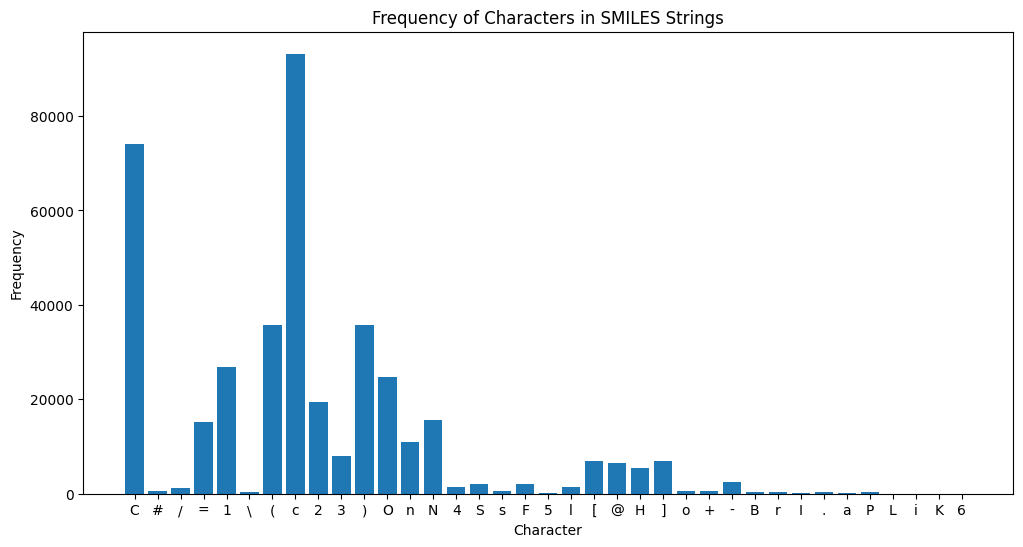

In [31]:
from collections import Counter

# Combine all SMILES strings into a single list of characters
all_smiles = []
[all_smiles.extend(smiles) for smiles in smiles_list]

# Count the occurrences of each character
char_counts = Counter(all_smiles)

# Extract characters and their counts
characters = list(char_counts.keys())
counts = list(char_counts.values())

# Create the bar plot
plt.figure(figsize=(12, 6))
plt.bar(characters, counts)
plt.xlabel('Character')
plt.ylabel('Frequency')
plt.title('Frequency of Characters in SMILES Strings')
plt.show()

In [32]:
# Convert to numpy array
X = np.array(padded_smiles_list)

# Create the target sequences (shifted by one time step)
y = np.zeros((X.shape[0], X.shape[1], len(vocab)))
for i, seq in enumerate(X):
    y[i, :-1, :] = seq[1:, :]  # Shifted by one time step
    y[i, -1, chars_to_index['<EOS>']] = 1  # Last step as <EOS>

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Visualize 10 samples of X and y
for i in range(1):
    print(f"Sample {i+1}:")
    print("X padded:", decode_sequence(X[i]))
    print("y padded:", decode_sequence(y[i]))
    print("X:", strip_special_tokens(decode_sequence(X[i])))
    print("y:", strip_special_tokens(decode_sequence(y[i])))
    print()

Sample 1:
X padded: C#C/C=C1\CCC(c2cccc3ccccc23)C(=O)O1<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>
y padded: #C/C=C1\CCC(c2cccc3ccccc23)C(=O)O1<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><EOS>
X: C#C/C=C1\CCC(c2cccc3ccccc23)C(=O)O1
y: #C/C=C1\CCC(c2cccc3ccccc23)C(=O)O1



In [33]:
import tensorflow as tf
MODEL_DIM = 256
EPOCHS = 150
BATCH_SIZE = 64
DROPOUT = 0.1
NUM_HEADS = 4
LEARNING_RATE = 1e-3

# Build the model with self-attention
input_layer = Input(shape=(max_length, len(vocab)))
lstm_layer = LSTM(MODEL_DIM, return_sequences=True)(input_layer)
attention_layer = MultiHeadAttention(num_heads=NUM_HEADS, key_dim=MODEL_DIM)(lstm_layer, lstm_layer)
norm_layer = LayerNormalization(epsilon=1e-6)(attention_layer + lstm_layer)
dropout_layer = Dropout(DROPOUT)(norm_layer)
output_layer = TimeDistributed(Dense(len(vocab), activation='softmax'))(dropout_layer)

model = Model(inputs=input_layer, outputs=output_layer)


# Compile the model
model.compile(loss=focal_loss(), optimizer='adam', metrics=['accuracy'])

# Configure early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model and include validation data
model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/150
125/125 ━━━━━━━━━━━━━━━━━━━━ 33s 97ms/step - accuracy: 0.1611 - loss: 0.1826 - val_accuracy: 0.2412 - val_loss: 0.0800
Epoch 2/150
125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - accuracy: 0.2386 - loss: 0.0815 - val_accuracy: 0.2597 - val_loss: 0.0669
Epoch 3/150
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - accuracy: 0.2583 - loss: 0.0684 - val_accuracy: 0.2738 - val_loss: 0.0570
Epoch 4/150
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - accuracy: 0.2714 - loss: 0.0596 - val_accuracy: 0.2866 - val_loss: 0.0495
Epoch 5/150
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - accuracy: 0.2865 - loss: 0.0496 - val_accuracy: 0.3209 - val_loss: 0.0302
Epoch 6/150
125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - accuracy: 0.3395 - loss: 0.0236 - val_accuracy: 0.3902 - val_loss: 0.0048
Epoch 7/150
125/125 ━━━━━━━━━━━━━━━━━━━━ 15s 96ms/step - accuracy: 0.3970 - loss: 0.0037 - val_accuracy: 0.4017 - val_loss: 0.0016
Epoch 8/150
125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - accuracy: 0.3979 - loss: 0.0032

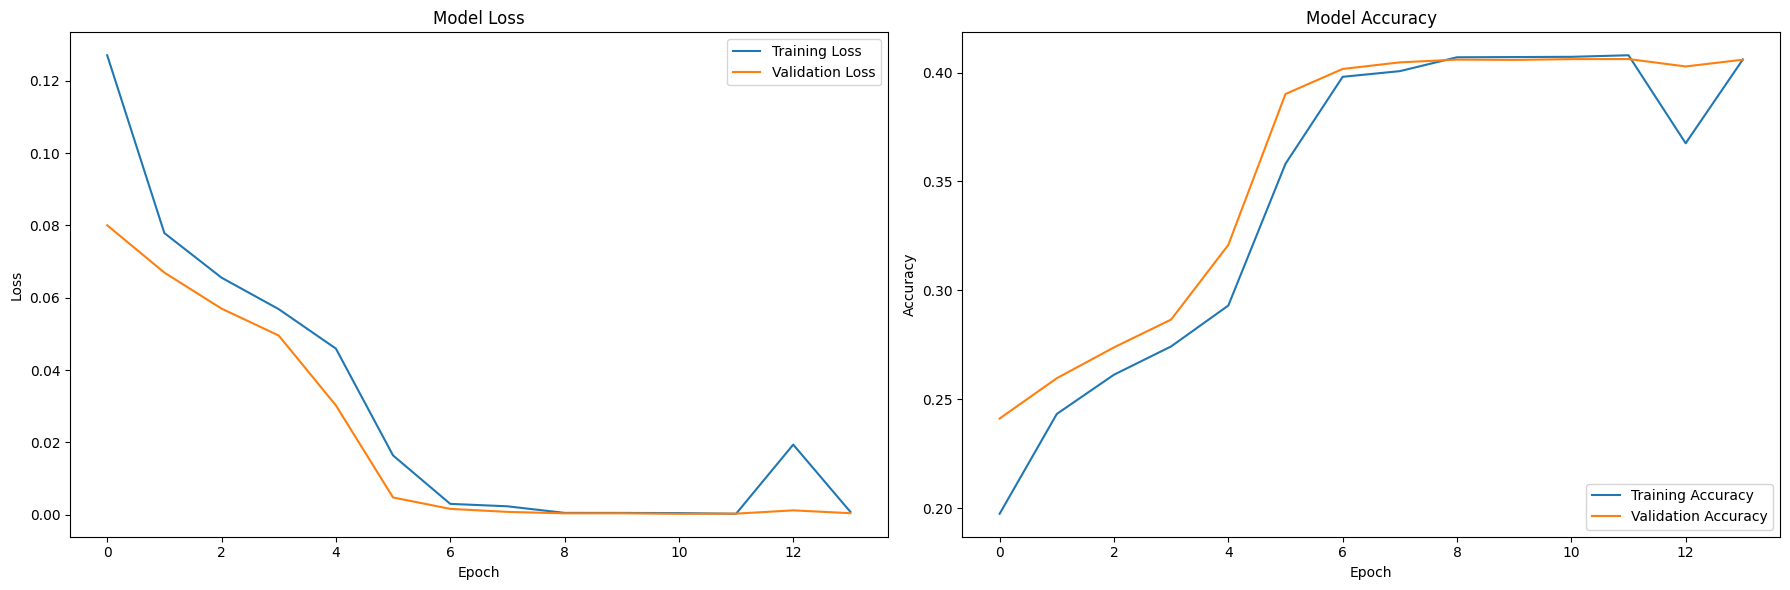

In [34]:
# Plot training & validation loss values
plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
plt.plot(model.history.history['loss'], label='Training Loss')
plt.plot(model.history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(model.history.history['accuracy'], label='Training Accuracy')
plt.plot(model.history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

In [35]:
# Example usage
seed_smiles = "C#C/C=C1\\CCC(c2cccc3ccccc23)C(=O)O1"  # Use a starting seed SMILES string
seed_smile = ""
seed_smiles_list = []
for char in seed_smiles:
  seed_smile += char
  seed_smiles_list.append(seed_smile)

generated_smiles_list = []
i = 1
for smiles_string in tqdm(seed_smiles_list):

  generated_smiles = generate_smiles(model, vocab, chars_to_index, index_to_chars, max_length, smiles_string, max_tokens=len(seed_smiles) - i)
  generated_smiles_list.append(generated_smiles)
  i += 1


100%|██████████| 35/35 [00:56<00:00,  1.62s/it]


In [36]:
seed_smiles_list

['C',
 'C#',
 'C#C',
 'C#C/',
 'C#C/C',
 'C#C/C=',
 'C#C/C=C',
 'C#C/C=C1',
 'C#C/C=C1\\',
 'C#C/C=C1\\C',
 'C#C/C=C1\\CC',
 'C#C/C=C1\\CCC',
 'C#C/C=C1\\CCC(',
 'C#C/C=C1\\CCC(c',
 'C#C/C=C1\\CCC(c2',
 'C#C/C=C1\\CCC(c2c',
 'C#C/C=C1\\CCC(c2cc',
 'C#C/C=C1\\CCC(c2ccc',
 'C#C/C=C1\\CCC(c2cccc',
 'C#C/C=C1\\CCC(c2cccc3',
 'C#C/C=C1\\CCC(c2cccc3c',
 'C#C/C=C1\\CCC(c2cccc3cc',
 'C#C/C=C1\\CCC(c2cccc3ccc',
 'C#C/C=C1\\CCC(c2cccc3cccc',
 'C#C/C=C1\\CCC(c2cccc3ccccc',
 'C#C/C=C1\\CCC(c2cccc3ccccc2',
 'C#C/C=C1\\CCC(c2cccc3ccccc23',
 'C#C/C=C1\\CCC(c2cccc3ccccc23)',
 'C#C/C=C1\\CCC(c2cccc3ccccc23)C',
 'C#C/C=C1\\CCC(c2cccc3ccccc23)C(',
 'C#C/C=C1\\CCC(c2cccc3ccccc23)C(=',
 'C#C/C=C1\\CCC(c2cccc3ccccc23)C(=O',
 'C#C/C=C1\\CCC(c2cccc3ccccc23)C(=O)',
 'C#C/C=C1\\CCC(c2cccc3ccccc23)C(=O)O',
 'C#C/C=C1\\CCC(c2cccc3ccccc23)C(=O)O1']

In [37]:
validity, uniqueness, novelty, unique_smiles = evaluate_generated_smiles(generated_smiles_list, smiles_list)
print(f"Percent valid: {validity}")
print(f"Percent unique: {uniqueness}")
print(f"Percent novel: {novelty}")
print(unique_smiles)

Percent valid: 14.285714285714285
Percent unique: 5.714285714285714
Percent novel: 11.428571428571429
['C#CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC', 'C#C/C=C/C/C/C/C/C/C/C/C/C/C/C/C/C/C']


Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 166s 2s/step - accuracy: 0.5835 - loss: 1.7887 - val_accuracy: 0.7605 - val_loss: 0.8199
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 137ms/step - accuracy: 0.7617 - loss: 0.7881 - val_accuracy: 0.7930 - val_loss: 0.6438
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - accuracy: 0.7942 - loss: 0.6371 - val_accuracy: 0.8174 - val_loss: 0.5512
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 137ms/step - accuracy: 0.8179 - loss: 0.5516 - val_accuracy: 0.8389 - val_loss: 0.4877
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 140ms/step - accuracy: 0.8334 - loss: 0.5018 - val_accuracy: 0.8521 - val_loss: 0.4456
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 138ms/step - accuracy: 0.8475 - loss: 0.4587 - val_accuracy: 0.8592 - val_loss: 0.4215
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 141ms/step - accuracy: 0.8553 - loss: 0.4326 - val_accuracy: 0.8677 - val_loss: 0.3961
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 141ms/step - accuracy: 0.8624 - loss: 0.4111 - val_accuracy:

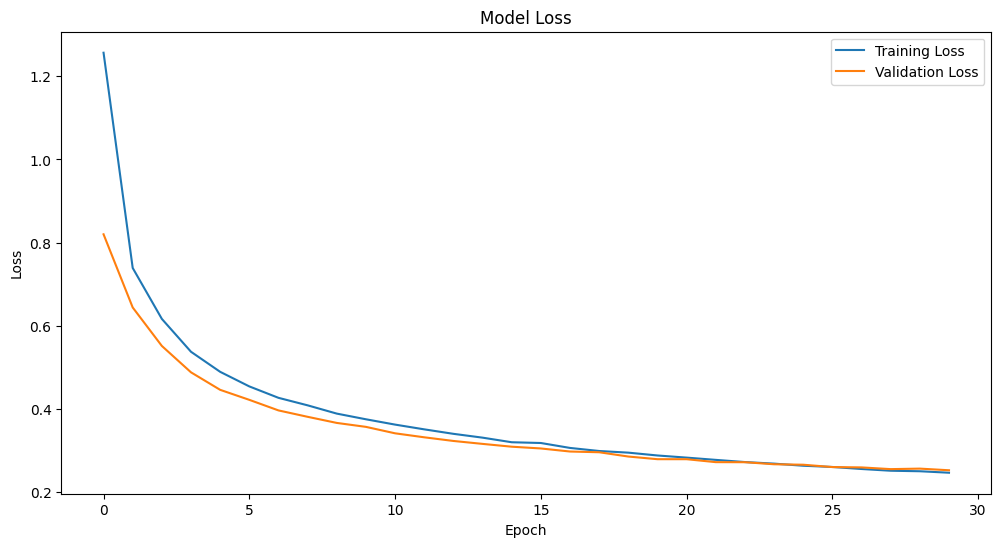

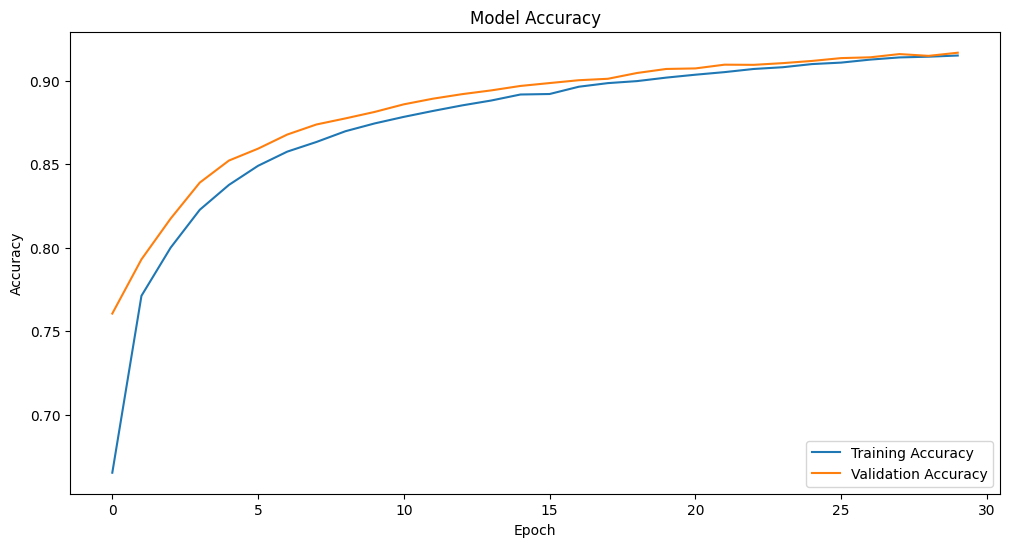

In [35]:
# Decoder only

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, MultiHeadAttention, LayerNormalization, Dense, Dropout, Add, TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed, Activation, MultiHeadAttention, LayerNormalization, Dropout, Input
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from tensorflow.keras.models import Model
from rdkit import RDLogger
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import Adam

# Constants for the model
MODEL_DIM = 128
NUM_HEADS = 4
DROPOUT = 0.1
EPOCHS = 30
BATCH_SIZE = 128  # Adjust based on memory availability
LEARNING_RATE = 1e-3  # Adjusted learning rate
NUM_LAYERS = 8
TEMPERATURE = 1.0  # Temperature for generation
CLIPVALUE = 1.0  # Gradient clipping value

# Example SMILES list
smiles_list = lip_df.iloc[:10000]['canonical_smiles'].tolist()

# Add special tokens with reserved indices
special_tokens = ['<PAD>', '<SOS>', '<EOS>']
vocab = special_tokens + list(set("".join(smiles_list)))  # Ensure special tokens are at the beginning

# Create character-to-index and index-to-character mappings
chars_to_index = {char: index for index, char in enumerate(vocab)}
index_to_chars = {index: char for index, char in enumerate(vocab)}

# Define the maximum length for padding (adding 2 for the <SOS> and <EOS> tokens)
max_length = max(len(smiles) for smiles in smiles_list) + 2

# Encode all SMILES strings
encoded_smiles_list = [[chars_to_index['<SOS>']] + [chars_to_index[char] for char in smiles] + [chars_to_index['<EOS>']] for smiles in smiles_list]

# Pad sequences to the same length using <PAD> token
padded_smiles_list = pad_sequences(encoded_smiles_list, maxlen=max_length, padding='post', value=chars_to_index['<PAD>'])

# Convert to numpy array
X = np.array(padded_smiles_list)

# Create the target sequences (shifted by one time step)
y = np.zeros_like(X)
y[:, :-1] = X[:, 1:]
y[:, -1] = chars_to_index['<PAD>']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Positional Encoding Function
def positional_encoding(position, d_model):
    angle_rads = np.arange(position)[:, np.newaxis] / np.power(10000, (2 * (np.arange(d_model)[np.newaxis, :] // 2)) / np.float32(d_model))
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

# Build the GPT-like decoder-only model
def build_decoder_only_model(input_shape, vocab_size, model_dim, num_heads, dropout_rate, num_layers):
    inputs = Input(shape=input_shape)
    x = Embedding(input_dim=vocab_size, output_dim=model_dim, mask_zero=True)(inputs)

    # Add positional encoding
    pos_encoding = positional_encoding(input_shape[0], model_dim)
    x = Add()([x, pos_encoding[:, :input_shape[0], :]])

    for _ in range(num_layers):
        # Decoder block
        attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=model_dim)(x, x, attention_mask=tf.linalg.band_part(tf.ones((input_shape[0], input_shape[0])), -1, 0))
        attn_output = Dropout(dropout_rate)(attn_output)
        out1 = LayerNormalization(epsilon=1e-6)(x + attn_output)

        ffn_output = Dense(model_dim, activation='relu')(out1)
        ffn_output = Dense(model_dim)(ffn_output)
        ffn_output = Dropout(dropout_rate)(ffn_output)
        x = LayerNormalization(epsilon=1e-6)(out1 + ffn_output)

    outputs = TimeDistributed(Dense(vocab_size, activation='softmax'))(x)
    model = Model(inputs, outputs)
    return model

decoder_only_model = build_decoder_only_model(input_shape=(max_length,), vocab_size=len(vocab), model_dim=MODEL_DIM, num_heads=NUM_HEADS, dropout_rate=DROPOUT, num_layers=NUM_LAYERS)

# Compile the model with gradient clipping
optimizer = Adam(learning_rate=ExponentialDecay(
    initial_learning_rate=LEARNING_RATE,
    decay_steps=10000,
    decay_rate=0.9,
    staircase=True
), clipvalue=CLIPVALUE)

decoder_only_model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Configure early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = decoder_only_model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [36]:
# Function to generate SMILES strings with temperature scaling
def generate_smiles(model, start_token, max_length, chars_to_index, index_to_chars, temperature=1.0):
    # Initialize the input sequence with the start token
    input_seq = [chars_to_index[start_token]]
    for _ in range(max_length - 1):
        # Pad the sequence
        padded_seq = pad_sequences([input_seq], maxlen=max_length, padding='post', value=chars_to_index['<PAD>'])
        # Predict the next character
        pred = model.predict(padded_seq, verbose=0)
        pred = pred[0][len(input_seq) - 1]

        # Apply temperature scaling
        pred = np.log(pred + 1e-9) / temperature
        exp_pred = np.exp(pred)
        pred = exp_pred / np.sum(exp_pred)
        next_char = np.random.choice(len(pred), p=pred)
        # Append the next character to the sequence
        input_seq.append(next_char)
        # If EOS token is generated, stop the generation
        if next_char == chars_to_index['<EOS>']:
            break
    # Convert the sequence of indices to characters
    smiles = ''.join([index_to_chars[i] for i in input_seq if i != chars_to_index['<PAD>'] and i != chars_to_index['<EOS>']])
    print(smiles.split("<SOS>")[-1])
    return smiles.split("<SOS>")[-1]

def evaluate_generated_smiles(generated_smiles_list):
    from rdkit import Chem
    from rdkit import RDLogger

    # Function to check the validity of generated SMILES strings using RDKit
    def is_valid_smiles(smiles):
        mol = Chem.MolFromSmiles(smiles)
        return mol is not None

    # Suppress RDKit warnings
    RDLogger.DisableLog('rdApp.*')

    valid_smiles = []

    for smiles in generated_smiles_list:
        if is_valid_smiles(smiles) and len(smiles) > 0:
            valid_smiles.append(smiles)

    validity = len(valid_smiles) / len(generated_smiles_list) * 100
    unique = len(list(set(valid_smiles))) / len(valid_smiles) * 100

    # Re-enable RDKit warnings if needed
    RDLogger.EnableLog('rdApp.*')

    return validity, unique, list(set(valid_smiles))

# Generate a new SMILES string
new_smiles = generate_smiles(decoder_only_model, start_token='<SOS>', max_length=max_length, chars_to_index=chars_to_index, index_to_chars=index_to_chars, temperature=TEMPERATURE)
print(f"Generated SMILES: {new_smiles}")
generated_smiles_list = []
for i in tqdm(range(100)):
    generated_smiles = generate_smiles(decoder_only_model, start_token='<SOS>', max_length=max_length, chars_to_index=chars_to_index, index_to_chars=index_to_chars, temperature=TEMPERATURE)
    generated_smiles_list.append(generated_smiles)

validity, uniqueness, unique_valid_smiles = evaluate_generated_smiles(generated_smiles_list)
print(f"\nPercent valid: {validity:.3f}%")
print(f"Percent unique: {uniqueness:.3f}%")
print(unique_valid_smiles)

CC(C)(C)C(=O)NCCCOc1ccc([N+](=O)[O-])cc1
Generated SMILES: CC(C)(C)C(=O)NCCCOc1ccc([N+](=O)[O-])cc1


  1%|          | 1/100 [00:02<03:35,  2.17s/it]

COc1ccc(CN2Cc3nc(N)nc4ccccc4C2)cc1


  2%|▏         | 2/100 [00:04<03:48,  2.33s/it]

Nc1nc2c(cc2cnc(Oc3ccc(F)cc3)c(=O)n2C)C1


  3%|▎         | 3/100 [00:07<03:48,  2.36s/it]

O=C1c2c(I)cccc3C[C@@H](c2ccc(F)cc2)N1


  4%|▍         | 4/100 [00:09<04:01,  2.52s/it]

CCCC(=O)Nc1ccc(C(=O)NCc2cc(F)c(F)c(F)c2)cc1


  5%|▌         | 5/100 [00:14<05:02,  3.19s/it]

Oc1ccc2c(c1)CN=C3[C@@H](C1C2)CC(Cc1cc[nH]cn1C3)C1CCCC2


  6%|▌         | 6/100 [00:18<05:31,  3.52s/it]

CC(C)(C#N)C(=O)N[C@H](Cc1ccc(F)cc1)C(=O)NC(CC(F)C)c1nc2ccccc12


  7%|▋         | 7/100 [00:20<04:50,  3.13s/it]

CC(C)(C)C(=O)Nc1ccc(Sc2ccccc2)c[nH]1


  8%|▊         | 8/100 [00:24<04:57,  3.24s/it]

O=C(Cn1c(-c2ccc(F)cc2)nc(F)c1=O)N/C=C/C1CN(CC(F)(F)F)CC1


  9%|▉         | 9/100 [00:25<04:01,  2.65s/it]

COc1ccc(C2=NCCN2)cc1


 10%|█         | 10/100 [00:26<03:19,  2.22s/it]

Nc1nc2ccccc23n1


 11%|█         | 11/100 [00:30<03:46,  2.55s/it]

CCC(N)Cc1ccc2c(c1)CN(C)C(=O)c1ccccc1O2


 12%|█▏        | 12/100 [00:33<04:15,  2.90s/it]

COc1ccc(S(=O)(=O)N(C)CC[C@H](O)C(=O)N2CCc3cc(cc2OC)O3)cc1


 13%|█▎        | 13/100 [00:36<04:20,  3.00s/it]

Nc1ccc(S(=O)(=O)N2C[C@H](O)[C@H]2CCCc3cc(c3)OCO2)cc1


 14%|█▍        | 14/100 [00:39<04:05,  2.86s/it]

COc1csc(SCc2ccc3ccccc3n2c1C/C=C(N)C(C)C


 15%|█▌        | 15/100 [00:42<04:01,  2.84s/it]

COc1ccccc1N1CCN(CCCNS(=O)(=O)c2ccccc2)CC1


 16%|█▌        | 16/100 [00:46<04:26,  3.17s/it]

CCC(=O)NCCCCNc1cnc2c1S(=O)(=O)Nc1cccc(C)c1Ka+]


 17%|█▋        | 17/100 [00:49<04:16,  3.09s/it]

CC(C)(C)C(=O)NCCCN1c2c(Sc3ccc(Cl)cc3)CC1C(=O)O


 18%|█▊        | 18/100 [00:52<04:08,  3.03s/it]

COC(=O)C[C@H](Cc1ccc(F)cc1F)n1cnc2c(c1)CN(C)C2


 19%|█▉        | 19/100 [00:54<03:52,  2.87s/it]

CC(C)OC(=O)c1ccc2c(c1)NC(CNCC1=O)[C@H]2O


 20%|██        | 20/100 [00:57<03:48,  2.86s/it]

CCC(=O)NCCc1c2n(c3ccc(Cl)cc13)CCCc1ccccc1


 21%|██        | 21/100 [01:00<03:50,  2.92s/it]

Cc1cc2c(c1)NC(=O)Nc1c(Cl)ccc(Cl)c1O2


 22%|██▏       | 22/100 [01:03<03:58,  3.05s/it]

COc1ccc(S(=O)(=O)C(CCCc2ccc(CC(=O)NCCCC3=O)s2)cc1


 23%|██▎       | 23/100 [01:04<03:05,  2.41s/it]

Cc1cn(N)cc(N)n1


 24%|██▍       | 24/100 [01:07<03:09,  2.49s/it]

NC(=O)CCc1ccc(-n2nc(C(F)(F)F)c2c(c1F)=OCCC2


 25%|██▌       | 25/100 [01:09<02:49,  2.27s/it]

Cc1ccn(CCCCCC(=O)C(=O)O)c1


 26%|██▌       | 26/100 [01:11<02:50,  2.31s/it]

COc1cc(NCc2cnc3nc(N)nc(N)c3c2C)ccc1OC


 27%|██▋       | 27/100 [01:14<03:07,  2.57s/it]

Cn1c(=O)sc2cc(F)cc(Cc3ccc(F)cc3)c2oc1=O


 28%|██▊       | 28/100 [01:17<03:05,  2.58s/it]

CC(C)NCC(O)COc1ccccc1Cc1ccccc1


 29%|██▉       | 29/100 [01:20<03:21,  2.83s/it]

O=C(O)C(=O)c1ccc(NC(=O)c2ccc(-c3ccc(F)cc3)cc2)cc(F)c1


 30%|███       | 30/100 [01:22<02:58,  2.55s/it]

Oc1ccc(C2CCN3CCCC3)c[nH]c2cc1


 31%|███       | 31/100 [01:24<02:41,  2.34s/it]

CSc1cn(C2=NNCCN2)c(C)c2ccccc21


 32%|███▏      | 32/100 [01:27<02:46,  2.45s/it]

CC(C)(C)c1ccc([C@H]2CN3CC(O)C(C(C)C3)C2)cc1


 33%|███▎      | 33/100 [01:29<02:36,  2.34s/it]

COc1ccc(C(=O)NCc2ccncc2)cc1


 34%|███▍      | 34/100 [01:31<02:26,  2.22s/it]

Oc1nc2cccc4c2n1)CCCCC3


 35%|███▌      | 35/100 [01:34<02:45,  2.55s/it]

CCCCn1c(=O)c2nc(-c3ccc(F)cc3)[nH]c2n(CCC)c1=O


 36%|███▌      | 36/100 [01:36<02:36,  2.45s/it]

CC(C)(C)NC(=O)[C@@H]1CCC[C@H]1C(=O)O


 37%|███▋      | 37/100 [01:39<02:38,  2.52s/it]

CC(C)(C)CCCC(n1ncnc1-c1nc(-c2ccccc2)sc1nn2C


 38%|███▊      | 38/100 [01:41<02:29,  2.41s/it]

CN(C)CC/C=C(\NC(=O)C1CC1(C)C)C(=O)O


 39%|███▉      | 39/100 [01:44<02:33,  2.51s/it]

COCCOc1ccc(-c2nc(-c3ccc(C)c(C)c3)n2)cc1


 40%|████      | 40/100 [01:48<03:05,  3.09s/it]

CCn1c(=O)c2nc(-c3ccc(S(=N)(=O)NCC)cc3)[nH]c2n(CC)c1=O


 41%|████      | 41/100 [01:51<02:51,  2.91s/it]

CN1CCC2(c3cccc(O)c3)CCC1CC1CO=C(=O)CCC1


 42%|████▏     | 42/100 [01:54<02:53,  2.99s/it]

CCOc1ccc(S(=O)(=O)N2CCN(CC(=O)Oc3cc(F)cc(F)c3)C2)cc1


 43%|████▎     | 43/100 [01:57<02:47,  2.94s/it]

CC(=O)Nc1cc2nc(Cl)c(=O)n(-c3ccc(Br)cc3)nc2c1


 44%|████▍     | 44/100 [02:00<02:44,  2.94s/it]

CC(C)NCC(O)COc1ccccc1C(=O)c2c(C)cc(F)cc21


 45%|████▌     | 45/100 [02:04<03:03,  3.33s/it]

Cc1cccc(Cc2n(Cc3ccc(F)cc3)c(=O)[nH]c2-c2ccncc23)c1


 46%|████▌     | 46/100 [02:05<02:24,  2.68s/it]

c1ccc(C2=NCCN2)cc1


 47%|████▋     | 47/100 [02:08<02:28,  2.80s/it]

CC(=O)c1cccc2c1CC(C(CN1CC1)N(C(=O)Nc3ccc(F)cc3)CC1


 48%|████▊     | 48/100 [02:10<02:16,  2.62s/it]

COc1ccc(Sc2cnccc2)cc1CN=C(O)C(=O)NO


 49%|████▉     | 49/100 [02:16<02:55,  3.44s/it]

CC[C@H](C)[C@@H](S)C(=O)[C@@H](C(=O)N[C@H](Cc1ccc(F)cc1)C(=O)N[C@H]1CCC(C)C)C)O


 50%|█████     | 50/100 [02:19<02:48,  3.37s/it]

CNS(=O)(=O)c1cccc(NCc2cccc3ccccc23)c1


 51%|█████     | 51/100 [02:21<02:23,  2.93s/it]

O=C1CC=C(=O)c2c1c1c(O)cccc12


 52%|█████▏    | 52/100 [02:23<02:07,  2.65s/it]

Nc1nc(S(N)(=O)=O)c(Cc2ccccc2)n1


 53%|█████▎    | 53/100 [02:27<02:30,  3.20s/it]

CCOC(=O)C1=C(OC(=O)[O-])N(C(=O)[C@H](C(=O)OC(C)C)C2=O)[C@H](O)C1.[Na+]


 54%|█████▍    | 54/100 [02:31<02:30,  3.28s/it]

C[C@]12CCC[C@@H]3c4cccc(c3)CC[C@]321CCCCc1ccccc21


 55%|█████▌    | 55/100 [02:32<01:58,  2.64s/it]

NC(O)CC(CS)CN


 56%|█████▌    | 56/100 [02:35<01:56,  2.66s/it]

C=Cc1nc(C)c(N)nc1-c1cccc(Cl)c1


 57%|█████▋    | 57/100 [02:37<01:45,  2.45s/it]

O=C(Nc1ccc(Cl)cc1)OCCCCc1ccccc1


 58%|█████▊    | 58/100 [02:39<01:45,  2.51s/it]

COc1ccc(NC(=O)Nc2ccnc2C(=O)O)cc1Oc1ccccc1


 59%|█████▉    | 59/100 [02:43<01:55,  2.83s/it]

CCCCOc1ccccc1-c1nc2c(c(C)nn2CCc3c(cccc3n2)C(=O)NC)c(=O)O


 60%|██████    | 60/100 [02:47<02:06,  3.16s/it]

CCCN1C(=O)c2c(ncn2Cc2ccc(OC)c(OC)c2)C1=N[C@@H]1CCC[C@@H]12


 61%|██████    | 61/100 [02:49<01:53,  2.90s/it]

CS(=O)(=O)c1ccc2c(c1)CNCC2


 62%|██████▏   | 62/100 [02:51<01:44,  2.75s/it]

Oc1ccc(N2CCN(CCN3CCCC2O)CC3)cc1


 63%|██████▎   | 63/100 [02:53<01:33,  2.51s/it]

CCC(Cn1cnc(N2C(N)=NC(N)=NC2)s1


 64%|██████▍   | 64/100 [02:56<01:33,  2.58s/it]

CCCCN1CCN(C3CCCN3CC[C@H]2c3ccccc31)c1nc2cco12


 65%|██████▌   | 65/100 [02:59<01:31,  2.60s/it]

Cc1ccc2c(c1)CN(C(=O)Nc1nc2ccc(Cl)cc2)CCC1


 66%|██████▌   | 66/100 [03:03<01:47,  3.16s/it]

Cc1c(CNC(=O)[C@H](Cc2ccccc2)[C@@H](3CCCC3)CCCC2)nn2c(=O)cccc21


 67%|██████▋   | 67/100 [03:07<01:51,  3.39s/it]

CC(C)(C)[C@H](NC(=O)Nc1ccc(-c2ccc(O)cc2)cc1)C(=O)O


 68%|██████▊   | 68/100 [03:09<01:33,  2.93s/it]

CCc1c(C(=O)N[C@@H](C)O)C(=O)O


 69%|██████▉   | 69/100 [03:11<01:18,  2.52s/it]

CN1Cc2ccc(Cl)nc2C1=NCCN1


 70%|███████   | 70/100 [03:13<01:13,  2.45s/it]

CCc1cn(C2CCC2)c(NC(=O)c2ccccc2)n1C=O


 71%|███████   | 71/100 [03:15<01:10,  2.42s/it]

CCCNC(CC)c1nc(-c2cccc(-c3ccccc3)n2)sc1C


 72%|███████▏  | 72/100 [03:19<01:22,  2.96s/it]

COc1ccc2c(cc1C(F)(F)F)C(=O)N(C(=O)OCc1ccccc1)C(=O)NC2=O


 73%|███████▎  | 73/100 [03:24<01:30,  3.37s/it]

Cc1nc(N)ccc1CNC(=O)Nn1c(C)cc(OC)c(-c2cccc([N+](=O)[O-])c2)o1


 74%|███████▍  | 74/100 [03:26<01:14,  2.87s/it]

C/N=C(\N)S(=O)(=O)C12CCCC1


 75%|███████▌  | 75/100 [03:28<01:10,  2.81s/it]

COC(=O)c1ccc(C(=O)[O-])cc1C(=O)NCCC1CNCCC1


 76%|███████▌  | 76/100 [03:32<01:14,  3.11s/it]

C(C)CCn1nc(-c2cnc(N)c(N)c2)c(=O)n1CO


 77%|███████▋  | 77/100 [03:35<01:11,  3.09s/it]

NCc1cc(Cc2ccc(N)cc2)ccc1OC1CCCC1


 78%|███████▊  | 78/100 [03:37<01:03,  2.90s/it]

Cc1ccc(C(=O)OCCC(N)=O)cc1


 79%|███████▉  | 79/100 [03:41<01:06,  3.15s/it]

N=C(N)CC1C(=O)Nc2ccccc2C(=O)Nc1nc1nc(-c2ccc(F)cc2)sc1


 80%|████████  | 80/100 [03:44<01:01,  3.05s/it]

CCOc1ccc(S(=O)(=O)N(C)CCCc2ccc(C)cc2)cc1


 81%|████████  | 81/100 [03:46<00:54,  2.86s/it]

N#Cc1cccc(N2CCN(Cc3ccc(F)cc3)CC2)n1


 82%|████████▏ | 82/100 [03:49<00:50,  2.80s/it]

CC(C)(C)NCC(O)COC(=O)c1ccc(F)cc1


 83%|████████▎ | 83/100 [03:52<00:47,  2.79s/it]

Cc1ccc2c(c1)N(CCN1CCCC1)CCC1


 84%|████████▍ | 84/100 [03:54<00:40,  2.55s/it]

Nc1nc(N)c2nc(N)nc(N)n2n1


 85%|████████▌ | 85/100 [03:57<00:39,  2.62s/it]

COC(=O)/C=C/CC(=O)N1CCN(c2ccc(OC)cc2)CC1


 86%|████████▌ | 86/100 [03:58<00:31,  2.28s/it]

CC(C)c1cc2c(s1)CNCC2


 87%|████████▋ | 87/100 [04:01<00:32,  2.53s/it]

COc1cccc2c1CCC[C@H]2c1cccc2[C@H]1CCCN(CCC2)C1


 88%|████████▊ | 88/100 [04:04<00:30,  2.55s/it]

Oc1nc2ccccc2n2c(N)c3c(=O)ncnc3n12


 89%|████████▉ | 89/100 [04:08<00:34,  3.14s/it]

CCC/C=C(/C#N)Sc1cccc(/C(=C\CCC(=O)O)c2cccnc2)n1


 90%|█████████ | 90/100 [04:12<00:31,  3.17s/it]

CCOC(=O)C1C(=O)N=C(C)C(=O)N1CCc1ccc(C3CCCC3)ccc1


 91%|█████████ | 91/100 [04:14<00:27,  3.04s/it]

CC1=C(=O)c2c(C(=O)O)[nH]c3cccc([N+]2C)c1


 92%|█████████▏| 92/100 [04:16<00:22,  2.76s/it]

O=C(CC(=O)NC1CCC1)c1ccc(Cl)cc1


 93%|█████████▎| 93/100 [04:19<00:19,  2.75s/it]

CC(C)Cn1c(=O)n(CCC)c(=O)c2c1[nH]cn21


 94%|█████████▍| 94/100 [04:23<00:19,  3.20s/it]

Cn1c(=O)c2c(nc(/C=C/c3cccc(Cl)c3)n2C)n(CC)c1=O


 95%|█████████▌| 95/100 [04:28<00:18,  3.63s/it]

C[C@@H]1[C@H](C)=C(=O)O[C@@H]2[C@@](C)[C@H]2[C@H](C)[C@H]2[C@@H](C)C1


 96%|█████████▌| 96/100 [04:31<00:14,  3.57s/it]

CC(C)S(=O)(=O)Nc1nc(-c2ccc(OC)cc2)c2cc(OC)cc(F)c2n1


 97%|█████████▋| 97/100 [04:33<00:08,  2.89s/it]

C#n1sc2scnc(N)c2c1C


 98%|█████████▊| 98/100 [04:37<00:06,  3.15s/it]

CCn1c(=O)c2c(nc(/C=C/c3cccc(Cl)c3)n2C)n(C)c1=O


 99%|█████████▉| 99/100 [04:40<00:03,  3.23s/it]

O=C(O)C(=O)C(=O)c1cc(C(=O)O)c2ccccc2c1


100%|██████████| 100/100 [04:42<00:00,  2.82s/it]

CCN(CC)CCCc1ccc2cc(OC)ccc2c1

Percent valid: 47.000%
Percent unique: 100.000%
['CC(C)NCC(O)COc1ccccc1Cc1ccccc1', 'O=C(CC(=O)NC1CCC1)c1ccc(Cl)cc1', 'COc1ccc(C2=NCCN2)cc1', 'Cn1c(=O)sc2cc(F)cc(Cc3ccc(F)cc3)c2oc1=O', 'CC(C)S(=O)(=O)Nc1nc(-c2ccc(OC)cc2)c2cc(OC)cc(F)c2n1', 'Cn1c(=O)c2c(nc(/C=C/c3cccc(Cl)c3)n2C)n(CC)c1=O', 'Oc1ccc(N2CCN(CCN3CCCC2O)CC3)cc1', 'C=Cc1nc(C)c(N)nc1-c1cccc(Cl)c1', 'Cc1nc(N)ccc1CNC(=O)Nn1c(C)cc(OC)c(-c2cccc([N+](=O)[O-])c2)o1', 'Cc1ccn(CCCCCC(=O)C(=O)O)c1', 'COC(=O)/C=C/CC(=O)N1CCN(c2ccc(OC)cc2)CC1', 'CC(C)(C)NC(=O)[C@@H]1CCC[C@H]1C(=O)O', 'CC(=O)Nc1cc2nc(Cl)c(=O)n(-c3ccc(Br)cc3)nc2c1', 'CCCNC(CC)c1nc(-c2cccc(-c3ccccc3)n2)sc1C', 'COc1ccc(C(=O)NCc2ccncc2)cc1', 'CCCC(=O)Nc1ccc(C(=O)NCc2cc(F)c(F)c(F)c2)cc1', 'COCCOc1ccc(-c2nc(-c3ccc(C)c(C)c3)n2)cc1', 'COc1ccccc1N1CCN(CCCNS(=O)(=O)c2ccccc2)CC1', 'CCn1c(=O)c2nc(-c3ccc(S(=N)(=O)NCC)cc3)[nH]c2n(CC)c1=O', 'CCN(CC)CCCc1ccc2cc(OC)ccc2c1', 'Oc1ccc(C2CCN3CCCC3)c[nH]c2cc1', 'COC(=O)c1ccc(C(=O)[O-])cc1C(=O)NCCC1CNCCC1', 'COc1ccc(

In [38]:
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, MultiHeadAttention, LayerNormalization, Dense, Dropout, LSTM, Bidirectional, Add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt

# Constants for the model
MODEL_DIM = 256
NUM_HEADS = 4
DROPOUT = 0.1
EPOCHS = 30
BATCH_SIZE = 128  # Adjust based on memory availability
LEARNING_RATE = 1e-3  # Adjusted learning rate
NUM_LAYERS = 6
TEMPERATURE = 1.0  # Temperature for generation
CLIPVALUE = 1.0  # Gradient clipping value

# Example SMILES list
smiles_list = lip_df.iloc[:10000]['canonical_smiles'].tolist()

# Add special tokens with reserved indices
special_tokens = ['<PAD>', '<SOS>', '<EOS>']
vocab = special_tokens + list(set("".join(smiles_list)))  # Ensure special tokens are at the beginning

# Create character-to-index and index-to-character mappings
chars_to_index = {char: index for index, char in enumerate(vocab)}
index_to_chars = {index: char for index, char in enumerate(vocab)}

# Define the maximum length for padding (adding 2 for the <SOS> and <EOS> tokens)
max_length = max(len(smiles) for smiles in smiles_list) + 2

# Encode all SMILES strings
encoded_smiles_list = [[chars_to_index['<SOS>']] + [chars_to_index[char] for char in smiles] + [chars_to_index['<EOS>']] for smiles in smiles_list]

# Pad sequences to the same length using <PAD> token
padded_smiles_list = pad_sequences(encoded_smiles_list, maxlen=max_length, padding='post', value=chars_to_index['<PAD>'])

print(f"vocabulary: {vocab}")
print(f"Number of smiles strings: {len(smiles_list)}")
print(f"vocabulary length: {len(vocab)}")
print(f"Max Length: {max_length}")
print(f"Padded smiles list shape: {padded_smiles_list.shape}")

# Convert to numpy array
X = np.array(padded_smiles_list)

# Create the target sequences (shifted by one time step)
y = np.zeros_like(X)
y[:, :-1] = X[:, 1:]
y[:, -1] = chars_to_index['<PAD>']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Positional Encoding Function
def positional_encoding(position, d_model):
    angle_rads = np.arange(position)[:, np.newaxis] / np.power(10000, (2 * (np.arange(d_model)[np.newaxis, :] // 2)) / np.float32(d_model))
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

# Build the transformer model with LSTM layer
def build_transformer_lstm_model(input_shape, vocab_size, model_dim, num_heads, dropout_rate, num_layers):
    inputs = Input(shape=input_shape)
    x = Embedding(input_dim=vocab_size, output_dim=model_dim, mask_zero=True)(inputs)

    # Add positional encoding
    pos_encoding = positional_encoding(input_shape[0], model_dim)
    x = Add()([x, pos_encoding[:, :input_shape[0], :]])

    for _ in range(num_layers):
        attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=model_dim)(x, x)
        attn_output = Dropout(dropout_rate)(attn_output)
        out1 = LayerNormalization(epsilon=1e-6)(x + attn_output)

        ffn_output = Dense(model_dim, activation='relu')(out1)
        ffn_output = Dense(model_dim)(ffn_output)
        ffn_output = Dropout(dropout_rate)(ffn_output)
        x = LayerNormalization(epsilon=1e-6)(out1 + ffn_output)

    lstm_output = LSTM(model_dim, return_sequences=True)(x)
    outputs = TimeDistributed(Dense(vocab_size, activation='softmax'))(lstm_output)
    model = Model(inputs, outputs)
    return model

transformer_lstm_model = build_transformer_lstm_model(input_shape=(max_length,), vocab_size=len(vocab), model_dim=MODEL_DIM, num_heads=NUM_HEADS, dropout_rate=DROPOUT, num_layers=NUM_LAYERS)

# Compile the model with gradient clipping



# Configure early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Learning rate scheduler
lr_schedule = ExponentialDecay(
    initial_learning_rate=LEARNING_RATE,
    decay_steps=10000,
    decay_rate=0.9,
    staircase=True
)

optimizer = Adam(learning_rate=lr_schedule, clipvalue=CLIPVALUE)
transformer_lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
# Train the model with early stopping and learning rate scheduler
history = transformer_lstm_model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val, y_val), callbacks=[early_stopping])

vocabulary: ['<PAD>', '<SOS>', '<EOS>', 'L', '@', 'H', 'I', ']', '5', 'K', 'r', '1', '+', 'n', '\\', 'B', 'l', ')', 'O', '6', '.', 'a', '2', 'S', 'c', 'C', 'P', 'i', '[', '3', '=', '-', 's', 'F', '#', '4', 'o', '/', 'N', '(']
Number of smiles strings: 10000
vocabulary length: 40
Max Length: 99
Padded smiles list shape: (10000, 99)
Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 70s 435ms/step - accuracy: 0.5549 - loss: 1.8704 - val_accuracy: 0.6520 - val_loss: 1.2773
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 393ms/step - accuracy: 0.6457 - loss: 1.3004 - val_accuracy: 0.6555 - val_loss: 1.2534
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 41s 392ms/step - accuracy: 0.6515 - loss: 1.2689 - val_accuracy: 0.6558 - val_loss: 1.2500
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 25s 398ms/step - accuracy: 0.6539 - loss: 1.2540 - val_accuracy: 0.6555 - val_loss: 1.2547
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 41s 400ms/step - accuracy: 0.6484 - loss: 1.2699 - val_accuracy: 0.6513 - val_loss: 1.2579
Epoch 6/30
63/63 ━━━━━

KeyboardInterrupt: 

In [ ]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Function to generate SMILES strings with temperature scaling
def generate_smiles(model, start_token, max_length, chars_to_index, index_to_chars, temperature=1.0):
    # Initialize the input sequence with the start token
    input_seq = [chars_to_index[start_token]]
    for _ in range(max_length - 1):
        # Pad the sequence
        padded_seq = pad_sequences([input_seq], maxlen=max_length, padding='post', value=chars_to_index['<PAD>'])
        # Predict the next character
        pred = model.predict(padded_seq, verbose=0)
        pred = pred[0][len(input_seq) - 1]

        # Apply temperature scaling
        pred = np.log(pred + 1e-9) / temperature
        exp_pred = np.exp(pred)
        pred = exp_pred / np.sum(exp_pred)
        next_char = np.random.choice(len(pred), p=pred)
        # Append the next character to the sequence
        input_seq.append(next_char)
        # If EOS token is generated, stop the generation
        if next_char == chars_to_index['<EOS>']:
            break
    # Convert the sequence of indices to characters
    smiles = ''.join([index_to_chars[i] for i in input_seq if i != chars_to_index['<PAD>'] and i != chars_to_index['<EOS>']])
    print(smiles.split("<SOS>")[-1])
    return smiles.split("<SOS>")[-1]

def evaluate_generated_smiles(generated_smiles_list):
    from rdkit import Chem
    from rdkit import RDLogger

    # Function to check the validity of generated SMILES strings using RDKit
    def is_valid_smiles(smiles):
        mol = Chem.MolFromSmiles(smiles)
        return mol is not None

    # Suppress RDKit warnings
    RDLogger.DisableLog('rdApp.*')

    valid_smiles = []

    for smiles in generated_smiles_list:
        if is_valid_smiles(smiles) and len(smiles) > 0:
            valid_smiles.append(smiles)

    validity = len(valid_smiles) / len(generated_smiles_list) * 100
    unique = len(list(set(valid_smiles))) / len(valid_smiles) * 100

    # Re-enable RDKit warnings if needed
    RDLogger.EnableLog('rdApp.*')

    return validity, unique, list(set(valid_smiles))

# Generate a new SMILES string
new_smiles = generate_smiles(transformer_lstm_model, start_token='<SOS>', max_length=max_length, chars_to_index=chars_to_index, index_to_chars=index_to_chars, temperature=TEMPERATURE)
print(f"Generated SMILES: {new_smiles}")
generated_smiles_list = []
for i in tqdm(range(100)):
    generated_smiles = generate_smiles(transformer_lstm_model, start_token='<SOS>', max_length=max_length, chars_to_index=chars_to_index, index_to_chars=index_to_chars, temperature=TEMPERATURE)
    generated_smiles_list.append(generated_smiles)

validity, uniqueness, unique_valid_smiles = evaluate_generated_smiles(generated_smiles_list)
print(f"\nPercent valid: {validity:.3f}%")
print(f"Percent unique: {uniqueness:.3f}%")
print(unique_valid_smiles)

In [ ]:
transformer_lstm_model.save("/content/drive/MyDrive/InspiritAI/1:1Mentorship/sanjay_oruganti/TLSTM_256_L6_H4.h5")

In [ ]:
X_train.shape

In [40]:
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, MultiHeadAttention, LayerNormalization, Dense, Dropout, LSTM, Bidirectional, Add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt

# Constants for the model
MODEL_DIM = 256
NUM_HEADS = 4
DROPOUT = 0.1
EPOCHS = 30
BATCH_SIZE = 128  # Adjust based on memory availability
LEARNING_RATE = 1e-3  # Adjusted learning rate
NUM_LAYERS = 6
TEMPERATURE = 1.0  # Temperature for generation
CLIPVALUE = 1.0  # Gradient clipping value

# Example SMILES list
smiles_list = lip_df.iloc[:10000]['canonical_smiles'].tolist()

# Add special tokens with reserved indices
special_tokens = ['<PAD>', '<SOS>', '<EOS>']
vocab = special_tokens + list(set("".join(smiles_list)))  # Ensure special tokens are at the beginning

# Create character-to-index and index-to-character mappings
chars_to_index = {char: index for index, char in enumerate(vocab)}
index_to_chars = {index: char for index, char in enumerate(vocab)}

# Define the maximum length for padding (adding 2 for the <SOS> and <EOS> tokens)
max_length = max(len(smiles) for smiles in smiles_list) + 2

# Encode all SMILES strings
encoded_smiles_list = [[chars_to_index['<SOS>']] + [chars_to_index[char] for char in smiles] + [chars_to_index['<EOS>']] for smiles in smiles_list]

# Pad sequences to the same length using <PAD> token
padded_smiles_list = pad_sequences(encoded_smiles_list, maxlen=max_length, padding='post', value=chars_to_index['<PAD>'])

print(f"vocabulary: {vocab}")
print(f"Number of smiles strings: {len(smiles_list)}")
print(f"vocabulary length: {len(vocab)}")
print(f"Max Length: {max_length}")
print(f"Padded smiles list shape: {padded_smiles_list.shape}")

# Convert to numpy array
X = np.array(padded_smiles_list)

# Create the target sequences (shifted by one time step)
y = np.zeros_like(X)
y[:, :-1] = X[:, 1:]
y[:, -1] = chars_to_index['<PAD>']

# Positional Encoding Function
def positional_encoding(position, d_model):
    angle_rads = np.arange(position)[:, np.newaxis] / np.power(10000, (2 * (np.arange(d_model)[np.newaxis, :] // 2)) / np.float32(d_model))
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

def transformer_encoder(vocab_size, max_len, num_heads, dff, d_model, num_layers, rate=0.1):
    inputs = Input(shape=(max_len,))

    # Embedding layer
    x = Embedding(vocab_size, d_model)(inputs)
    pos_encoding = positional_encoding(max_len, d_model)
    x = Add()([x, pos_encoding[:, :max_len, :]])

    # Stack of Encoder layers
    for _ in range(num_layers):
        x = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(x, x)
        x = Dropout(rate)(x)
        x = LayerNormalization(epsilon=1e-6)(x)

        ffn_output = Dense(dff, activation='relu')(x)
        ffn_output = Dense(d_model)(ffn_output)
        x = LayerNormalization(epsilon=1e-6)(x + ffn_output)

    return Model(inputs, x)

def transformer_decoder(vocab_size, max_len, num_heads, dff, d_model, num_layers, rate=0.1):
    inputs = Input(shape=(max_len,))
    enc_outputs = Input(shape=(max_len, d_model))

    # Embedding layer
    x = Embedding(vocab_size, d_model)(inputs)
    pos_encoding = positional_encoding(max_len, d_model)
    x = Add()([x, pos_encoding[:, :max_len, :]])

    # Stack of Decoder layers
    for _ in range(num_layers):
        attention1 = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(x, x)
        attention1 = LayerNormalization(epsilon=1e-6)(attention1 + x)

        attention2 = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(attention1, enc_outputs)
        attention2 = LayerNormalization(epsilon=1e-6)(attention2 + attention1)

        ffn_output = Dense(dff, activation='relu')(attention2)
        ffn_output = Dense(d_model)(ffn_output)
        x = LayerNormalization(epsilon=1e-6)(attention2 + ffn_output)

    outputs = Dense(vocab_size, activation='softmax')(x)

    return Model([inputs, enc_outputs], outputs)

def build_transformer(vocab_size, max_len, num_heads, dff, d_model, num_layers, rate=0.1):
    encoder_inputs = Input(shape=(max_len,))
    decoder_inputs = Input(shape=(max_len,))

    # Build Encoder and Decoder
    encoder = transformer_encoder(vocab_size, max_len, num_heads, dff, d_model, num_layers, rate)
    decoder = transformer_decoder(vocab_size, max_len, num_heads, dff, d_model, num_layers, rate)

    # Encoder output
    enc_output = encoder(encoder_inputs)

    # Decoder output
    dec_output = decoder([decoder_inputs, enc_output])

    # Final model
    model = Model([encoder_inputs, decoder_inputs], dec_output)

    return model

# Prepare the decoder inputs
decoder_input_data = np.zeros_like(X)
decoder_input_data[:, 1:] = X[:, :-1]
decoder_input_data[:, 0] = chars_to_index['<SOS>']

# Split data for encoder, decoder, and targets
X_train_encoder, X_val_encoder, y_train, y_val, X_train_decoder, X_val_decoder = train_test_split(
    X, y, decoder_input_data, test_size=0.2, random_state=42
)

# Build the model
model = build_transformer(vocab_size=len(vocab), max_len=max_length, num_heads=NUM_HEADS, dff=MODEL_DIM*4, d_model=MODEL_DIM, num_layers=NUM_LAYERS, rate=DROPOUT)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Learning rate scheduler
lr_schedule = ExponentialDecay(
    initial_learning_rate=LEARNING_RATE,
    decay_steps=10000,
    decay_rate=0.9,
    staircase=True
)

optimizer = Adam(learning_rate=lr_schedule, clipvalue=CLIPVALUE)
# Compile the model with gradient clipping
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

# Train the model with encoder and decoder inputs
history = model.fit(
    [X_train_encoder, X_train_decoder], y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=([X_val_encoder, X_val_decoder], y_val),
    callbacks=[early_stopping]
)

vocabulary: ['<PAD>', '<SOS>', '<EOS>', 'L', '@', 'H', 'I', ']', '5', 'K', 'r', '1', '+', 'n', '\\', 'B', 'l', ')', 'O', '6', '.', 'a', '2', 'S', 'c', 'C', 'P', 'i', '[', '3', '=', '-', 's', 'F', '#', '4', 'o', '/', 'N', '(']
Number of smiles strings: 10000
vocabulary length: 40
Max Length: 99
Padded smiles list shape: (10000, 99)


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7             │ (None, 99)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_8             │ (None, 99)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_5 (Functional) │ (1, 99, 256)           │      9,481,216 │ input_layer_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_6 (Functional) │ (1, 99, 40)            │     15,805,992 │ input_layer_8[0][0],   │
│                           │                        │                │ functional_5[0][0]     │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 25,287,208 (96.46 MB)

 Trainable params: 25,287,208 (96.46 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 190s 2s/step - accuracy: 0.4819 - loss: 2.7488 - val_accuracy: 0.5868 - val_loss: 1.7326
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 105s 813ms/step - accuracy: 0.5840 - loss: 1.7412 - val_accuracy: 0.5868 - val_loss: 1.7318
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 81s 807ms/step - accuracy: 0.5856 - loss: 1.7363 - val_accuracy: 0.5868 - val_loss: 1.7323
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 83s 826ms/step - accuracy: 0.5858 - loss: 1.7398 - val_accuracy: 0.5868 - val_loss: 1.7320
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 82s 825ms/step - accuracy: 0.5850 - loss: 1.7388 - val_accuracy: 0.5868 - val_loss: 1.7319
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 82s 826ms/step - accuracy: 0.5855 - loss: 1.7409 - val_accuracy: 0.5868 - val_loss: 1.7319
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 81s 807ms/step - accuracy: 0.5853 - loss: 1.7377 - val_accuracy: 0.5868 - val_loss: 1.7325
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 82s 807ms/step - accuracy: 0.5853 - loss: 1.7396 - val_accur

In [41]:
# Function to generate SMILES strings with temperature scaling
def generate_smiles(model, start_token, max_length, chars_to_index, index_to_chars, temperature=1.0):
    # Initialize the input sequence with the start token
    input_seq = [chars_to_index[start_token]]
    for _ in range(max_length - 1):
        # Pad the sequence
        padded_seq = pad_sequences([input_seq], maxlen=max_length, padding='post', value=chars_to_index['<PAD>'])
        # Predict the next character
        pred = model.predict(padded_seq, verbose=0)
        pred = pred[0][len(input_seq) - 1]

        # Apply temperature scaling
        pred = np.log(pred + 1e-9) / temperature
        exp_pred = np.exp(pred)
        pred = exp_pred / np.sum(exp_pred)
        next_char = np.random.choice(len(pred), p=pred)
        # Append the next character to the sequence
        input_seq.append(next_char)
        # If EOS token is generated, stop the generation
        if next_char == chars_to_index['<EOS>']:
            break
    # Convert the sequence of indices to characters
    smiles = ''.join([index_to_chars[i] for i in input_seq if i != chars_to_index['<PAD>'] and i != chars_to_index['<EOS>']])
    print(smiles.split("<SOS>")[-1])
    return smiles.split("<SOS>")[-1]

def evaluate_generated_smiles(generated_smiles_list):
    from rdkit import Chem
    from rdkit import RDLogger

    # Function to check the validity of generated SMILES strings using RDKit
    def is_valid_smiles(smiles):
        mol = Chem.MolFromSmiles(smiles)
        return mol is not None

    # Suppress RDKit warnings
    RDLogger.DisableLog('rdApp.*')

    valid_smiles = []

    for smiles in generated_smiles_list:
        if is_valid_smiles(smiles) and len(smiles) > 0:
            valid_smiles.append(smiles)

    validity = len(valid_smiles) / len(generated_smiles_list) * 100
    unique = len(list(set(valid_smiles))) / len(valid_smiles) * 100

    # Re-enable RDKit warnings if needed
    RDLogger.EnableLog('rdApp.*')

    return validity, unique, list(set(valid_smiles))

# Generate a new SMILES string
new_smiles = generate_smiles(model, start_token='<SOS>', max_length=max_length, chars_to_index=chars_to_index, index_to_chars=index_to_chars, temperature=TEMPERATURE)
print(f"Generated SMILES: {new_smiles}")
generated_smiles_list = []
for i in tqdm(range(100)):
    generated_smiles = generate_smiles(transformer_lstm_model, start_token='<SOS>', max_length=max_length, chars_to_index=chars_to_index, index_to_chars=index_to_chars, temperature=TEMPERATURE)
    generated_smiles_list.append(generated_smiles)

validity, uniqueness, unique_valid_smiles = evaluate_generated_smiles(generated_smiles_list)
print(f"\nPercent valid: {validity:.3f}%")
print(f"Percent unique: {uniqueness:.3f}%")
print(unique_valid_smiles)

ValueError: Layer "functional_7" expects 2 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'data:0' shape=(1, 99) dtype=int32>]

In [ ]:
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, MultiHeadAttention, LayerNormalization, Dense, Dropout, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt

# Constants for the model
MODEL_DIM = 256
NUM_HEADS = 4
DROPOUT = 0.1
EPOCHS = 30
BATCH_SIZE = 64  # Adjust based on memory availability
LEARNING_RATE = 1e-3  # Adjusted learning rate
NUM_LAYERS = 4
TEMPERATURE = 1.0  # Temperature for generation

# Example SMILES list
smiles_list = lip_df.iloc[:10000]['canonical_smiles'].tolist()

# Add special tokens with reserved indices
special_tokens = ['<PAD>', '<SOS>', '<EOS>']
vocab = special_tokens + list(set("".join(smiles_list)))  # Ensure special tokens are at the beginning

# Create character-to-index and index-to-character mappings
chars_to_index = {char: index for index, char in enumerate(vocab)}
index_to_chars = {index: char for index, char in enumerate(vocab)}

# Define the maximum length for padding (adding 2 for the <SOS> and <EOS> tokens)
max_length = max(len(smiles) for smiles in smiles_list) + 2

# Encode all SMILES strings
encoded_smiles_list = [[chars_to_index['<SOS>']] + [chars_to_index[char] for char in smiles] + [chars_to_index['<EOS>']] for smiles in smiles_list]

# Pad sequences to the same length using <PAD> token
padded_smiles_list = pad_sequences(encoded_smiles_list, maxlen=max_length, padding='post', value=chars_to_index['<PAD>'])

print(f"vocabulary: {vocab}")
print(f"Number of smiles strings: {len(smiles_list)}")
print(f"vocabulary length: {len(vocab)}")
print(f"Max Length: {max_length}")
print(f"Padded smiles list shape: {padded_smiles_list.shape}")

# Convert to numpy array
X = np.array(padded_smiles_list)

# Create the target sequences (shifted by one time step)
y = np.zeros_like(X)
y[:, :-1] = X[:, 1:]
y[:, -1] = chars_to_index['<PAD>']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the transformer model with LSTM layer
def build_transformer_lstm_model(input_shape, vocab_size, model_dim, num_heads, dropout_rate, num_layers):
    inputs = Input(shape=input_shape)
    x = Embedding(input_dim=vocab_size, output_dim=model_dim)(inputs)

    for _ in range(num_layers):
        attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=model_dim)(x, x)
        attn_output = Dropout(dropout_rate)(attn_output)
        out1 = LayerNormalization(epsilon=1e-6)(x + attn_output)

        ffn_output = Dense(model_dim, activation='relu')(out1)
        ffn_output = Dense(model_dim)(ffn_output)
        ffn_output = Dropout(dropout_rate)(ffn_output)
        x = LayerNormalization(epsilon=1e-6)(out1 + ffn_output)

    lstm_output = LSTM(model_dim, return_sequences=True)(x)
    outputs = Dense(vocab_size, activation='softmax')(lstm_output)
    model = Model(inputs, outputs)
    return model

transformer_lstm_model = build_transformer_lstm_model(input_shape=(max_length,), vocab_size=len(vocab), model_dim=MODEL_DIM, num_heads=NUM_HEADS, dropout_rate=DROPOUT, num_layers=NUM_LAYERS)

# Compile the model
optimizer = Adam(learning_rate=LEARNING_RATE)
transformer_lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Configure early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * 0.9

lr_scheduler = LearningRateScheduler(scheduler)

# Train the model with early stopping and learning rate scheduler
history = transformer_lstm_model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val, y_val), callbacks=[early_stopping, lr_scheduler])

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()


In [ ]:
encoded_smiles_list

In [ ]:

# Function to generate SMILES strings with temperature scaling
def generate_smiles(model, start_token, max_length, chars_to_index, index_to_chars, temperature=1.0):
    # Initialize the input sequence with the start token
    input_seq = [chars_to_index[start_token]]
    for _ in range(max_length - 1):
        # Pad the sequence
        padded_seq = pad_sequences([input_seq], maxlen=max_length, padding='post', value=chars_to_index['<PAD>'])
        # Predict the next character
        pred = model.predict(padded_seq, verbose=0)
        pred = pred[0][len(input_seq) - 1]
        # Apply temperature scaling
        pred = np.log(pred + 1e-9) / temperature
        exp_pred = np.exp(pred)
        pred = exp_pred / np.sum(exp_pred)
        next_char = np.random.choice(len(pred), p=pred)
        # Append the next character to the sequence
        input_seq.append(next_char)
        # If EOS token is generated, stop the generation
        if next_char == chars_to_index['<EOS>']:
            break
    # Convert the sequence of indices to characters
    smiles = ''.join([index_to_chars[i] for i in input_seq if i != chars_to_index['<PAD>'] and i != chars_to_index['<EOS>']])
    return smiles

# Generate a new SMILES string
new_smiles = generate_smiles(transformer_lstm_model, start_token='<SOS>', max_length=max_length, chars_to_index=chars_to_index, index_to_chars=index_to_chars, temperature=TEMPERATURE)
print(f"Generated SMILES: {new_smiles}")


In [ ]:
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

In [ ]:
# Generate SMILES function
def generate_smiles(model, vocab, chars_to_index, index_to_chars, max_length, seed_smiles, max_tokens=100):
    # Encode the seed SMILES string
    encoded_smiles = [chars_to_index[char] for char in seed_smiles]
    encoded_smiles = pad_sequences([encoded_smiles], maxlen=max_length, padding='post', value=chars_to_index['<PAD>'])

    # Generate SMILES string
    generated_smiles = seed_smiles
    for _ in range(max_tokens):
        prediction = model.predict(encoded_smiles, verbose=0)[0]
        next_char_index = np.argmax(prediction[len(generated_smiles)-1])
        if next_char_index >= len(index_to_chars):
            break  # Invalid index
        next_char = index_to_chars[next_char_index]
        if next_char == '<EOS>':
            break
        generated_smiles += next_char
        if len(generated_smiles) >= max_length:
            break
        encoded_smiles = pad_sequences([[chars_to_index[char] for char in generated_smiles]], maxlen=max_length, padding='post', value=chars_to_index['<PAD>'])

    return generated_smiles

# Evaluate generated SMILES function
def evaluate_generated_smiles(generated_smiles_list, training_smiles_list):
    from rdkit import Chem
    from rdkit import RDLogger

    # Function to check the validity of generated SMILES strings using RDKit
    def is_valid_smiles(smiles):
        mol = Chem.MolFromSmiles(smiles)
        return mol is not None

    # Suppress RDKit warnings
    RDLogger.DisableLog('rdApp.*')

    valid_count = 0
    novel_count = 0
    valid_novel_smiles = set()

    for smiles in generated_smiles_list:
        if is_valid_smiles(smiles):
            valid_count += 1
            if smiles not in training_smiles_list:
                novel_count += 1
                valid_novel_smiles.add(smiles)

    validity = valid_count / len(generated_smiles_list) * 100
    uniqueness = len(valid_novel_smiles) / len(generated_smiles_list) * 100
    novelty = novel_count / len(generated_smiles_list) * 100

    # Re-enable RDKit warnings if needed
    RDLogger.EnableLog('rdApp.*')

    return validity, uniqueness, novelty, list(valid_novel_smiles)

# Generate SMILES strings
seed_smiles = "C#C/C=C1\\CCC(c2cccc3ccccc23)C(=O)O1"  # Use a starting seed SMILES string
seed_smile = ""
seed_smiles_list = []
for char in seed_smiles:
    seed_smile += char
    seed_smiles_list.append(seed_smile)

generated_smiles_list = []
i = 1
for smiles_string in tqdm(seed_smiles_list):
    generated_smiles = generate_smiles(transformer_model, vocab, chars_to_index, index_to_chars, max_length, smiles_string, max_tokens=len(seed_smiles) - i)
    generated_smiles_list.append(generated_smiles)
    i += 1

validity, uniqueness, novelty, unique_smiles = evaluate_generated_smiles(generated_smiles_list, smiles_list)
print(f"Percent valid: {validity}")
print(f"Percent unique: {uniqueness}")
print(f"Percent novel: {novelty}")
print(unique_smiles)
print(generated_smiles_list)

In [ ]:
generated_smiles_list

In [ ]:
## VAE
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LSTM, Lambda, RepeatVector, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm

# Constants for the model
MAX_LENGTH = 100  # Adjust as needed
LATENT_DIM = 50
EPOCHS = 150
BATCH_SIZE = 64
LEARNING_RATE = 1e-3
VOCAB_SIZE = len(vocab)


In [ ]:
# Example SMILES list
smiles_list = lip_df.iloc[:1000]['canonical_smiles'].tolist()

# Add special tokens with reserved indices
special_tokens = ['<PAD>', '<EOS>']
vocab = special_tokens + vocab  # Ensure special tokens are at the beginning

# Create character-to-index and index-to-character mappings
chars_to_index = {char: index for index, char in enumerate(vocab)}
index_to_chars = {index: char for index, char in enumerate(vocab)}

# Define the maximum length for padding (adding 1 for the <EOS> token)
max_length = max(len(smiles) for smiles in smiles_list) + 1

# Encode all SMILES strings
encoded_smiles_list = [create_smiles_table(s, len(vocab)) for s in smiles_list]

# Pad sequences to the same length using <PAD> token
padded_smiles_list = pad_sequences(encoded_smiles_list, maxlen=max_length, padding='post', value=chars_to_index['<PAD>'])

print(f"vocabulary: {vocab}")
print(f"Number of smiles strings: {len(smiles_list)}")
print(f"vocabulary length: {len(vocab)}")
print(f"Max Length: {max_length}")
print(f"Padded smiles list shape: {padded_smiles_list.shape}")

# Convert to numpy array
X = np.array(padded_smiles_list)

# Create the target sequences (shifted by one time step)
y = np.zeros((X.shape[0], X.shape[1], len(vocab)))
for i, seq in enumerate(X):
    y[i, :-1, :] = seq[1:, :]  # Shifted by one time step
    y[i, -1, chars_to_index['<EOS>']] = 1  # Last step as <EOS>

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Sampling function
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

# Encoder
inputs = Input(shape=(max_length, len(vocab)))
h = LSTM(256, return_sequences=True)(inputs)
h = LSTM(256)(h)
z_mean = Dense(LATENT_DIM)(h)
z_log_var = Dense(LATENT_DIM)(h)
z = Lambda(sampling, output_shape=(LATENT_DIM,))([z_mean, z_log_var])

# Decoder
decoder_h = LSTM(256, return_sequences=True)
decoder_mean = LSTM(256, return_sequences=True)
decoder_outputs = TimeDistributed(Dense(len(vocab), activation='softmax'))

h_decoded = RepeatVector(max_length)(z)
h_decoded = decoder_h(h_decoded)
x_decoded_mean = decoder_mean(h_decoded)
x_decoded_mean = decoder_outputs(x_decoded_mean)

# VAE model
vae = Model(inputs, x_decoded_mean)

# VAE loss
reconstruction_loss = binary_crossentropy(K.flatten(inputs), K.flatten(x_decoded_mean)) * max_length * len(vocab)
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)

vae.compile(optimizer='adam')
vae.summary()


In [ ]:
# Configure early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * 0.9

lr_scheduler = LearningRateScheduler(scheduler)

# Train the model with early stopping and learning rate scheduler
history = vae.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val, y_val), callbacks=[early_stopping, lr_scheduler])

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()


In [ ]:
# Pretrained model

In [ ]:
!pip install transformers torch


In [ ]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForMaskedLM

tokenizer = AutoTokenizer.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")
model = AutoModelForMaskedLM.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")
# Ensure the model is in evaluation mode
model.eval()


In [ ]:
# Example SMILES list (you can use your own dataset)
smiles_list = lip_df.iloc[:100]['canonical_smiles'].tolist()

# Tokenize the SMILES strings
encoded_inputs = tokenizer(smiles_list, padding=True, truncation=True, return_tensors="pt")

# Extract input IDs and attention masks
input_ids = encoded_inputs['input_ids']
attention_mask = encoded_inputs['attention_mask']

print(f"Input IDs shape: {input_ids.shape}")
print(f"Attention Mask shape: {attention_mask.shape}")


In [ ]:
from transformers import AutoTokenizer, AutoModel
from torch import nn, optim
import torch

class SMILESDecoder(nn.Module):
    def __init__(self, pretrained_model, vocab_size, hidden_dim):
        super(SMILESDecoder, self).__init__()
        self.bert = pretrained_model
        self.decoder = nn.Transformer(d_model=hidden_dim, num_decoder_layers=4)
        self.fc_out = nn.Linear(hidden_dim, vocab_size)

    def forward(self, input_ids, attention_mask, decoder_input_ids):
        # Get the outputs from the pre-trained model
        encoder_outputs = self.bert(input_ids, attention_mask=attention_mask).last_hidden_state

        # Ensure the decoder input IDs have the right shape
        decoder_input_ids = decoder_input_ids.unsqueeze(0) if len(decoder_input_ids.shape) == 1 else decoder_input_ids

        # Pass through the decoder
        decoder_outputs = self.decoder(encoder_outputs.permute(1, 0, 2), decoder_input_ids.permute(1, 0, 2))

        # Output layer
        logits = self.fc_out(decoder_outputs.permute(1, 0, 2))
        return logits

# Load the smaller pre-trained tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = AutoModel.from_pretrained("distilbert-base-uncased")

# Ensure the model is in evaluation mode
model.eval()

# Instantiate the SMILESDecoder model
vocab_size = len(tokenizer.vocab)
hidden_dim = model.config.hidden_size
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
smiles_decoder = SMILESDecoder(pretrained_model=model, vocab_size=vocab_size, hidden_dim=hidden_dim).to(device)

# Define optimizer and loss function
optimizer = optim.Adam(smiles_decoder.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)


In [ ]:
# Example SMILES list (use your own dataset)
smiles_list = lip_df.iloc[:100]['canonical_smiles'].tolist()

# Tokenize the SMILES strings
encoded_inputs = tokenizer(smiles_list, padding=True, truncation=True, return_tensors="pt")

# Extract input IDs and attention masks
input_ids = encoded_inputs['input_ids']
attention_mask = encoded_inputs['attention_mask']

# Create the target sequences (shifted by one time step)
decoder_input_ids = torch.zeros_like(input_ids)
decoder_input_ids[:, :-1] = input_ids[:, 1:]

# Move tensors to the appropriate device
input_ids = input_ids.to(device)
attention_mask = attention_mask.to(device)
decoder_input_ids = decoder_input_ids.to(device)

# Adjust batch size
BATCH_SIZE = 16

# Create a DataLoader
from torch.utils.data import DataLoader, TensorDataset

dataset = TensorDataset(input_ids, attention_mask, decoder_input_ids)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)


In [ ]:
# Example SMILES list (use your own dataset)
smiles_list = lip_df.iloc[:100]['canonical_smiles'].tolist()

# Tokenize the SMILES strings
encoded_inputs = tokenizer(smiles_list, padding=True, truncation=True, return_tensors="pt")

# Extract input IDs and attention masks
input_ids = encoded_inputs['input_ids']
attention_mask = encoded_inputs['attention_mask']

# Create the target sequences (shifted by one time step)
decoder_input_ids = torch.zeros_like(input_ids)
decoder_input_ids[:, :-1] = input_ids[:, 1:]

# Move tensors to the appropriate device
input_ids = input_ids.to(device)
attention_mask = attention_mask.to(device)
decoder_input_ids = decoder_input_ids.to(device)

# Adjust batch size
BATCH_SIZE = 8

# Create a DataLoader
from torch.utils.data import DataLoader, TensorDataset

dataset = TensorDataset(input_ids, attention_mask, decoder_input_ids)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)


In [ ]:
from torch.cuda.amp import GradScaler, autocast

scaler = GradScaler()

# Define the number of steps to accumulate gradients
accumulation_steps = 2

# Training loop with gradient accumulation and mixed precision
for epoch in range(EPOCHS):
    smiles_decoder.train()
    optimizer.zero_grad()

    for i, batch in enumerate(dataloader):
        input_ids_batch, attention_mask_batch, decoder_input_ids_batch = batch

        with autocast():
            # Forward pass
            outputs = smiles_decoder(input_ids_batch, attention_mask_batch, decoder_input_ids_batch)

            # Compute loss
            loss = criterion(outputs.view(-1, vocab_size), input_ids_batch[:, 1:].contiguous().view(-1)) / accumulation_steps

        # Backward pass
        scaler.scale(loss).backward()

        # Update model weights and reset gradients
        if (i + 1) % accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {loss.item() * accumulation_steps:.4f}")
